In [67]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999
print("EDA")

<IPython.core.display.Javascript object>

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
pd.set_option('display.max_row',111)
pd.set_option('display.max_column',111)

data = pd.read_excel("dataset.xlsx")
data.head()

Patient ID  Patient age quantile SARS-Cov-2 exam result  \
0  44477f75e8169d2                    13               negative   
1  126e9dd13932f68                    17               negative   
2  a46b4402a0e5696                     8               negative   
3  f7d619a94f97c45                     5               negative   
4  d9e41465789c2b5                    15               negative   

   Patient addmited to regular ward (1=yes, 0=no)  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   Patient addmited to semi-intensive unit (1=yes, 0=no)  \
0                                                  0       
1                                                  0       
2                                                  0       
3                                                  0       
4                                                  0       

   Patient addmited to intensive care unit (1=yes, 0=no)  Hematocrit  \
0                                                  0             NaN   
1                                                  0        0.236515   
2                                                  0             NaN   
3                                                  0             NaN   
4                                                  0             NaN   

   Hemoglobin  Platelets  Mean platelet volume   Red blood Cells  Lymphocytes  \
0         NaN        NaN                    NaN              NaN          NaN   
1    -0.02234  -0.517413               0.010677         0.102004     0.318366   
2         NaN        NaN                    NaN              NaN          NaN   
3         NaN        NaN                    NaN              NaN          NaN   
4         NaN        NaN                    NaN              NaN          NaN   

   Mean corpuscular hemoglobin concentration (MCHC)  Leukocytes  Basophils  \
0                                               NaN         NaN        NaN   
1                                          -0.95079    -0.09461  -0.223767   
2                                               NaN         NaN        NaN   
3                                               NaN         NaN        NaN   
4                                               NaN         NaN        NaN   

   Mean corpuscular hemoglobin (MCH)  Eosinophils  \
0                                NaN          NaN   
1                          -0.292269     1.482158   
2                                NaN          NaN   
3                                NaN          NaN   
4                                NaN          NaN   

   Mean corpuscular volume (MCV)  Monocytes  \
0                            NaN        NaN   
1                       0.166192   0.357547   
2                            NaN        NaN   
3                            NaN        NaN   
4                            NaN        NaN   

   Red blood cell distribution width (RDW)  Serum Glucose  \
0                                      NaN            NaN   
1                                -0.625073      -0.140648   
2                                      NaN            NaN   
3                                      NaN            NaN   
4                                      NaN            NaN   

  Respiratory Syncytial Virus   Influenza A   Influenza B Parainfluenza 1  \
0                         NaN           NaN           NaN             NaN   
1                not_detected  not_detected  not_detected    not_detected   
2                         NaN           NaN           NaN             NaN   
3                         NaN           NaN           NaN             NaN   
4                not_detected  not_detected  not_detected    not_detected   

  CoronavirusNL63 Rhinovirus/Enterovirus  Mycoplasma pneumoniae  \
0             NaN                    

1. Exploratory Data Analysis

Objectif :
Comprendre du mieux possible nos données (un petit pas en avant vaut mieux qu'un grand pas en arriere)
Développer une premiere stratégie de modélisation

Checklist de base

- Analyse de Forme :
- variable target : SARS-Cov-2 exam result
- lignes et colonnes : 5644, 111
- types de variables : qualitatives : 70, quantitatives : 41
- Analyse des valeurs manquantes : beaucoup de NaN (moitié des variables > 90% de NaN)
2 groupes de données 76% -> Test viral, 89% -> taux sanguins
- Analyse de Fond :
- Visualisation de la target :

10% de positifs (558 / 5000)
Signification des variables :

variables continues standardisées, skewed (asymétriques), test sanguin
age quantile : difficile d'interpreter ce graphique, clairement ces données ont été traitées, on pourrait penser 0-5, mais cela pourrait aussi etre une transformation mathématique. On peut pas savoir car la personne qui a mit ce dataset ne le précise nul part. Mais ca n'est pas tres important
variable qualitative : binaire (0, 1), viral, Rhinovirus qui semble tres élevée
Relation Variables / Target :

target / blood : les taux de Monocytes, Platelets, Leukocytes semblent liés au covid-19 -> hypothese a tester
target/age : les individus de faible age sont tres peu contaminés ? -> attention on ne connait pas l'age, et on ne sait pas de quand date le dataset (s'il s'agit des enfants on sait que les enfants sont touchés autant que les adultes). En revanche cette variable pourra etre intéressante pour la comparer avec les résultats de tests sanguins
target / viral : les doubles maladies sont tres rares. Rhinovirus/Enterovirus positif - covid-19 négatif ? -> hypothese a tester ? mais il est possible que la région est subie une épidémie de ce virus. De plus on peut tres bien avoir 2 virus en meme temps. Tout ca n'a aucun lien avec le covid-19
Analyse plus détaillée
Relation Variables / Variables :

blood_data / blood_data : certaines variables sont tres corrélées : +0.9 (a suveiller plus tard)
blood_data / age : tres faible corrélation entre age et taux sanguins
viral / viral : influenza rapid test donne de mauvais résultats, il fauda peut-etre la laisser tomber
relation maladie / blood data : Les taux sanguins entre malades et covid-19 sont différents
relation hospitalisation / est malade :
relation hospitalisation / blood : intéressant dans le cas ou on voudrait prédire dans quelle service un patient devrait aller
NaN analyse : viral : 1350(92/8), blood : 600(87/13), both : 90

hypotheses nulle (H0):
Les individus atteints du covid-19 ont des taux de Leukocytes, Monocytes, Platelets significativement différents

H0 = Les taux moyens sont ÉGAUX chez les individus positifs et négatifs
Les individus atteints d'une quelconque maladie ont des taux significativement différents

In [36]:
data.shape

(5644, 111)

In [37]:
df = data.copy()

In [38]:
df.dtypes

Patient ID                                                object
Patient age quantile                                       int64
SARS-Cov-2 exam result                                    object
Patient addmited to regular ward (1=yes, 0=no)             int64
Patient addmited to semi-intensive unit (1=yes, 0=no)      int64
Patient addmited to intensive care unit (1=yes, 0=no)      int64
Hematocrit                                               float64
Hemoglobin                                               float64
Platelets                                                float64
Mean platelet volume                                     float64
Red blood Cells                                          float64
Lymphocytes                                              float64
Mean corpuscular hemoglobin concentration (MCHC)         float64
Leukocytes                                               float64
Basophils                                                float64
Mean corpuscular hemoglob

In [39]:
df.dtypes.value_counts()

float64    70
object     37
int64       4
dtype: int64

<Axes: >

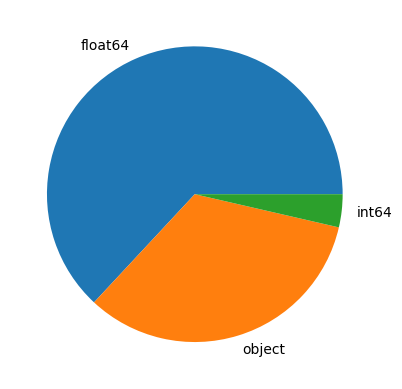

In [40]:
df.dtypes.value_counts().plot.pie()                          

<Axes: >

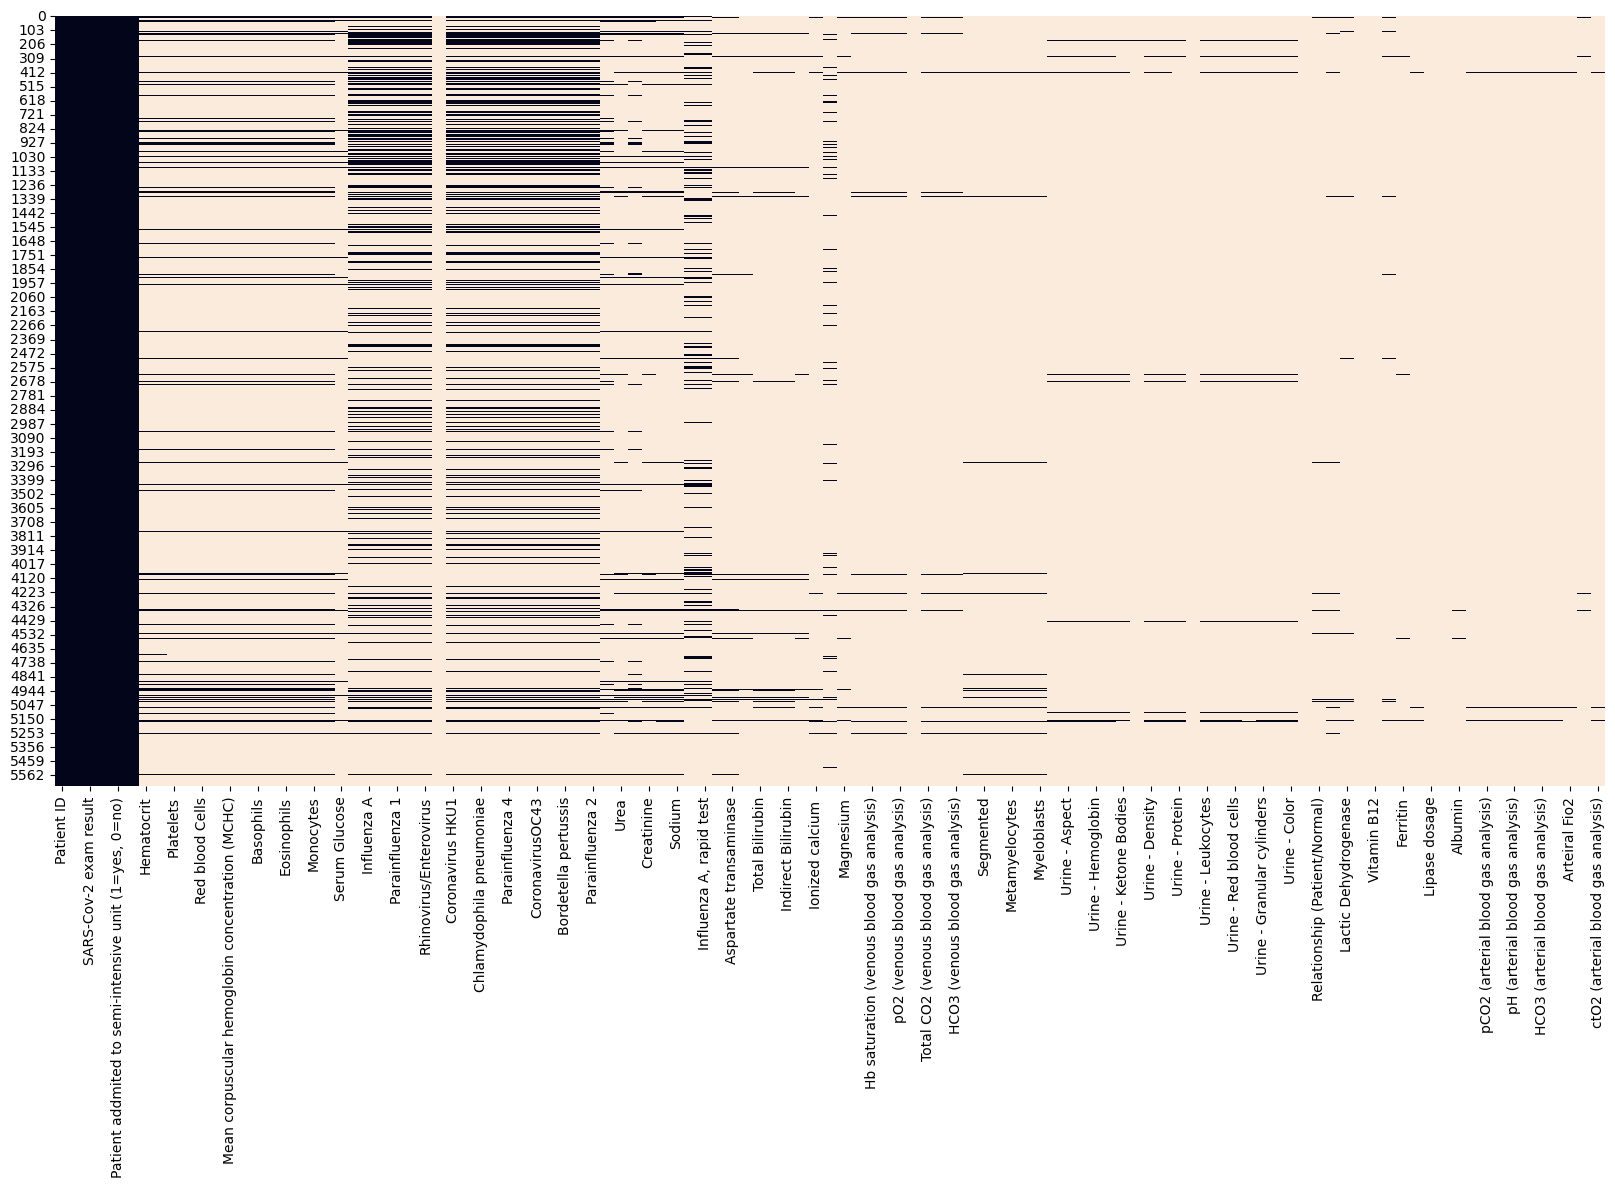

In [41]:
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(),cbar=False)

In [42]:
(df.isna().sum() / df.shape[0] * 100).sort_values(ascending=True)

Patient ID                                                 0.000000
Patient age quantile                                       0.000000
SARS-Cov-2 exam result                                     0.000000
Patient addmited to regular ward (1=yes, 0=no)             0.000000
Patient addmited to semi-intensive unit (1=yes, 0=no)      0.000000
Patient addmited to intensive care unit (1=yes, 0=no)      0.000000
Influenza B                                               76.009922
Respiratory Syncytial Virus                               76.009922
Influenza A                                               76.009922
Rhinovirus/Enterovirus                                    76.045358
Inf A H1N1 2009                                           76.045358
CoronavirusOC43                                           76.045358
Coronavirus229E                                           76.045358
Parainfluenza 4                                           76.045358
Adenovirus                                      

In [43]:
df = df[df.columns[(df.isna().sum() / df.shape[0] * 100) < 90]]

<Axes: >

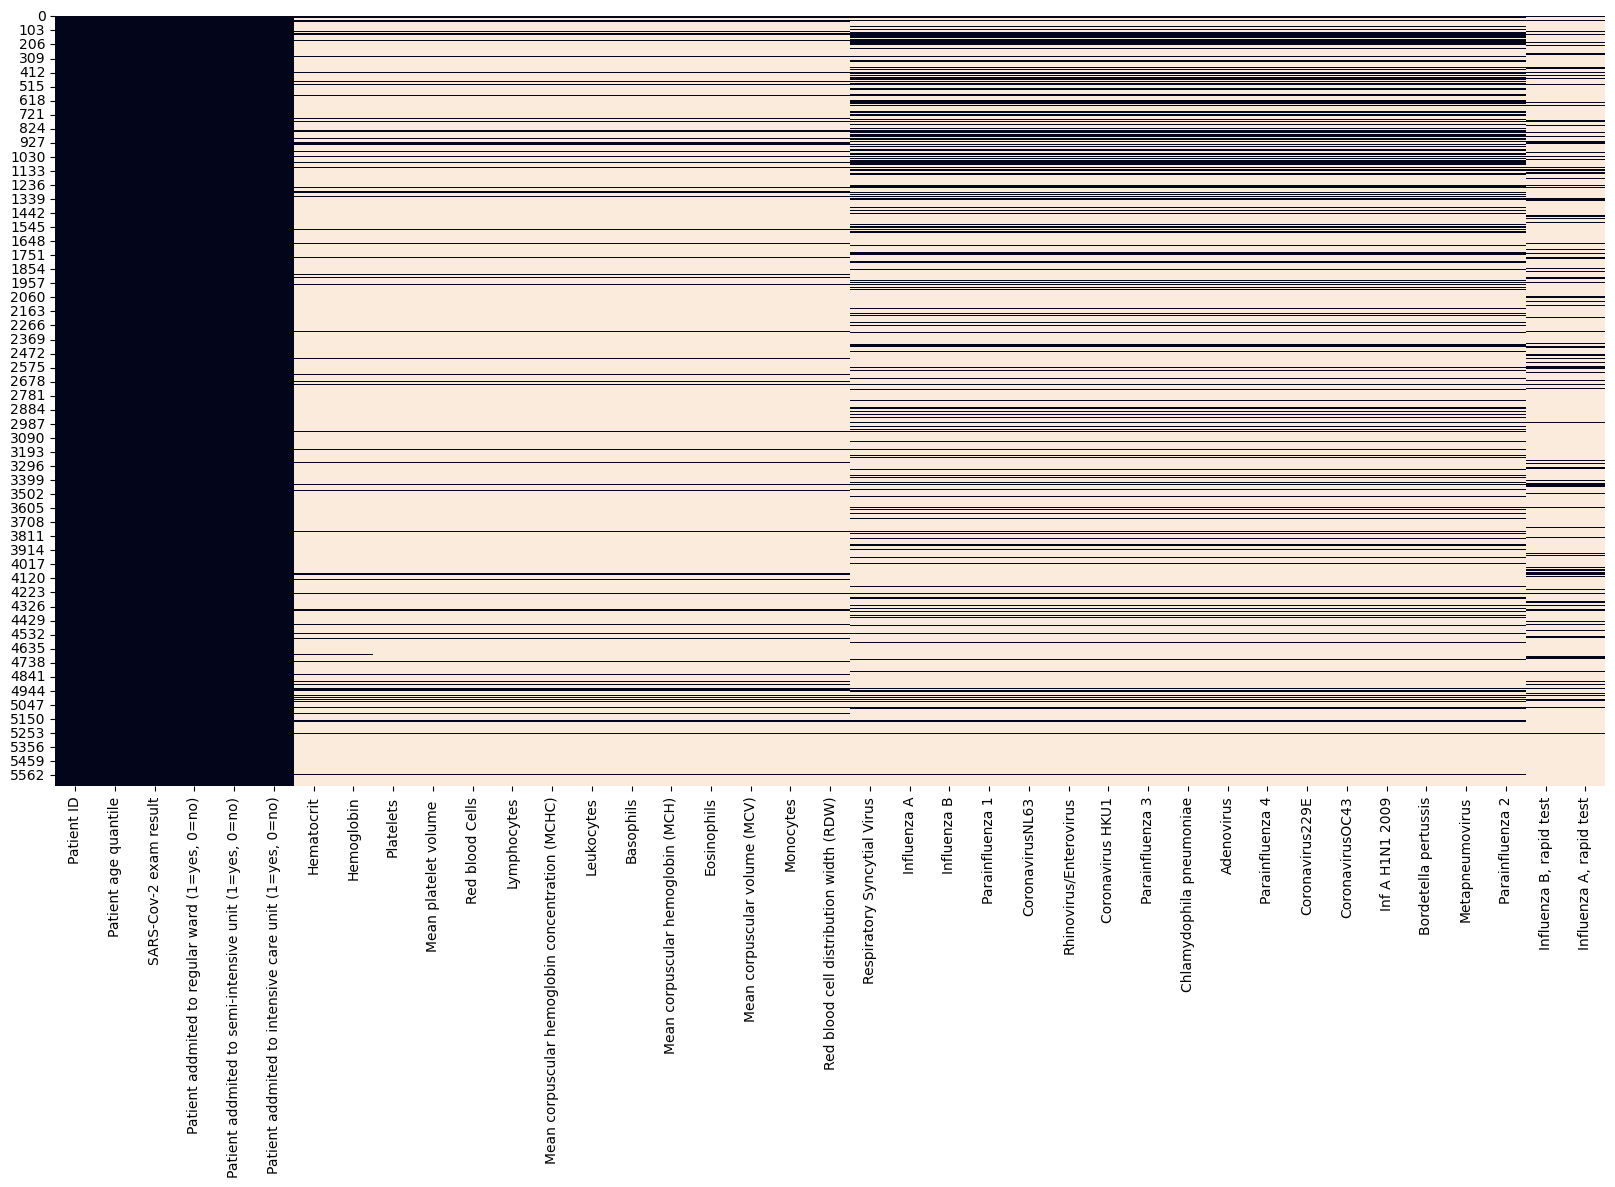

In [44]:
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(),cbar=False)

In [45]:
df.shape

(5644, 39)

In [46]:
df = df.drop('Patient ID',axis=1)

In [47]:
df.head()

Patient age quantile SARS-Cov-2 exam result  \
0                    13               negative   
1                    17               negative   
2                     8               negative   
3                     5               negative   
4                    15               negative   

   Patient addmited to regular ward (1=yes, 0=no)  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   Patient addmited to semi-intensive unit (1=yes, 0=no)  \
0                                                  0       
1                                                  0       
2                                                  0       
3                                                  0       
4                                                  0       

   Patient addmited to intensive care unit (1=yes, 0=no)  Hematocrit  \
0                                                  0             NaN   
1                                                  0        0.236515   
2                                                  0             NaN   
3                                                  0             NaN   
4                                                  0             NaN   

   Hemoglobin  Platelets  Mean platelet volume   Red blood Cells  Lymphocytes  \
0         NaN        NaN                    NaN              NaN          NaN   
1    -0.02234  -0.517413               0.010677         0.102004     0.318366   
2         NaN        NaN                    NaN              NaN          NaN   
3         NaN        NaN                    NaN              NaN          NaN   
4         NaN        NaN                    NaN              NaN          NaN   

   Mean corpuscular hemoglobin concentration (MCHC)  Leukocytes  Basophils  \
0                                               NaN         NaN        NaN   
1                                          -0.95079    -0.09461  -0.223767   
2                                               NaN         NaN        NaN   
3                                               NaN         NaN        NaN   
4                                               NaN         NaN        NaN   

   Mean corpuscular hemoglobin (MCH)  Eosinophils  \
0                                NaN          NaN   
1                          -0.292269     1.482158   
2                                NaN          NaN   
3                                NaN          NaN   
4                                NaN          NaN   

   Mean corpuscular volume (MCV)  Monocytes  \
0                            NaN        NaN   
1                       0.166192   0.357547   
2                            NaN        NaN   
3                            NaN        NaN   
4                            NaN        NaN   

   Red blood cell distribution width (RDW) Respiratory Syncytial Virus  \
0                                      NaN                         NaN   
1                                -0.625073                not_detected   
2                                      NaN                         NaN   
3                                      NaN                         NaN   
4                                      NaN                not_detected   

    Influenza A   Influenza B Parainfluenza 1 CoronavirusNL63  \
0           NaN           NaN             NaN             NaN   
1  not_detected  not_detected    not_detected    not_detected   
2           NaN           NaN             NaN             NaN   
3           NaN           NaN             NaN             NaN   
4  not_detected  not_detected    not_detected    not_detected   

  Rhinovirus/Enterovirus Coronavirus HKU1 Parainfluenza 3  \
0                    NaN              NaN             NaN   
1               detected     not_detected    not_detected   
2           

In [48]:
df['SARS-Cov-2 exam result'].value_counts()

negative    5086
positive     558
Name: SARS-Cov-2 exam result, dtype: int64

C:\Users\Fitiavana(GhosT)\AppData\Local\Temp\ipykernel_2400\3363295428.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])
C:\Users\Fitiavana(GhosT)\AppData\Local\Temp\ipykernel_2400\3363295428.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])
C:\Users\Fitiavana(GhosT)\AppDat

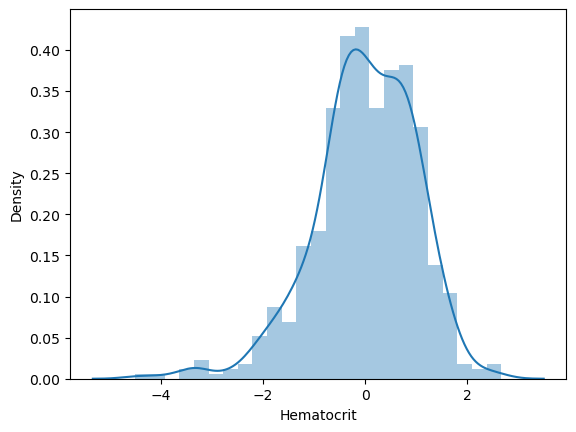

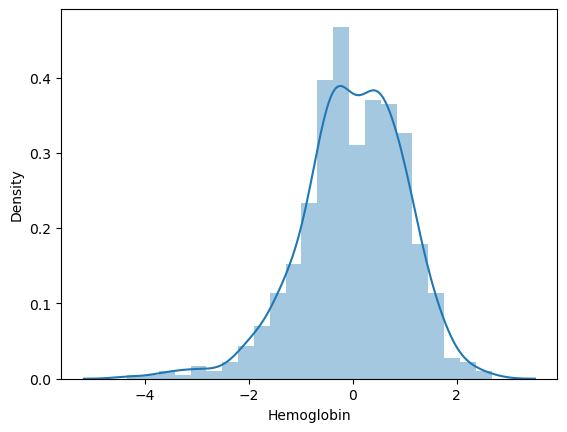

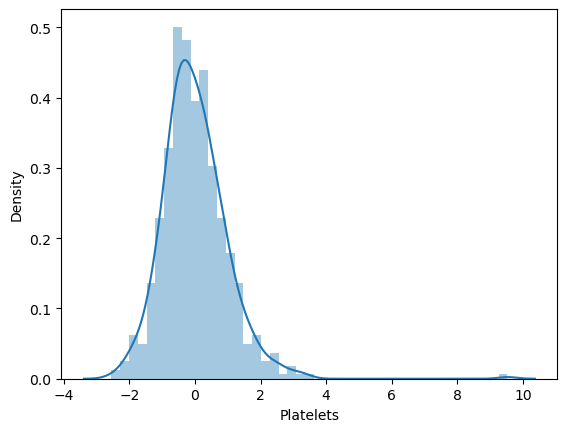

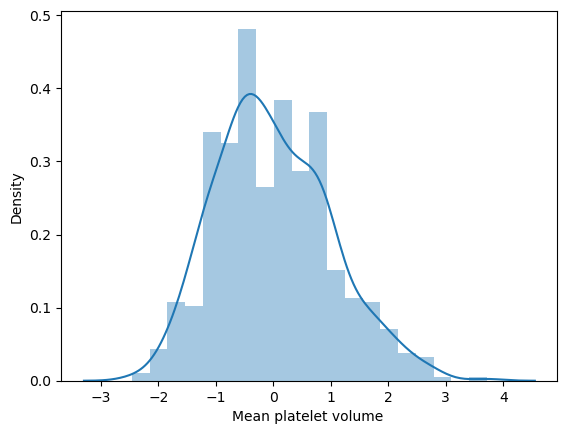

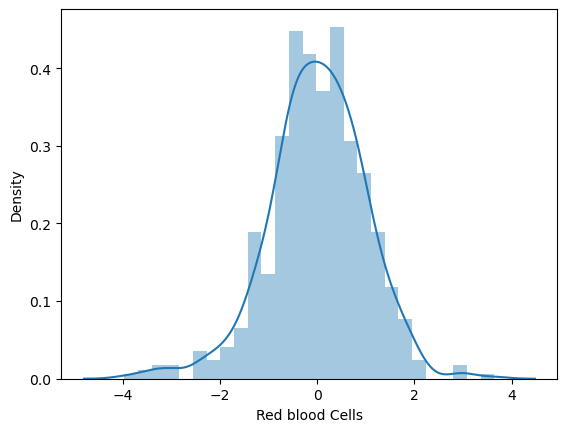

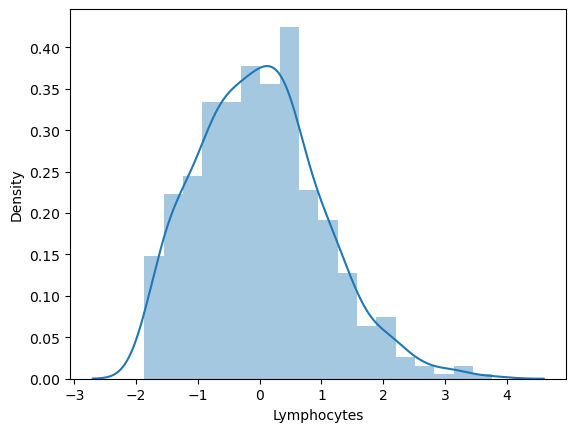

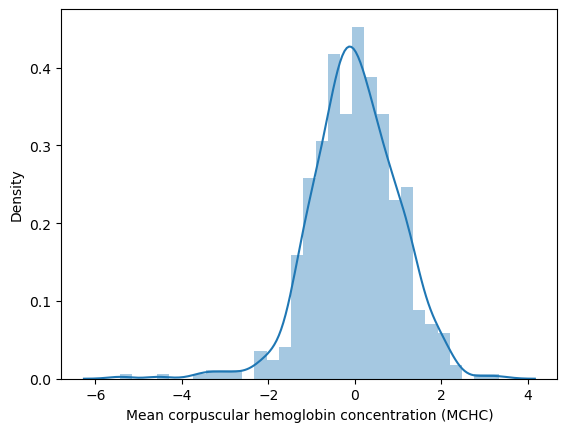

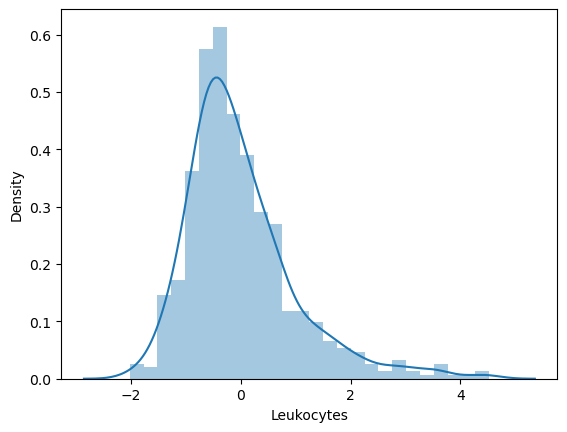

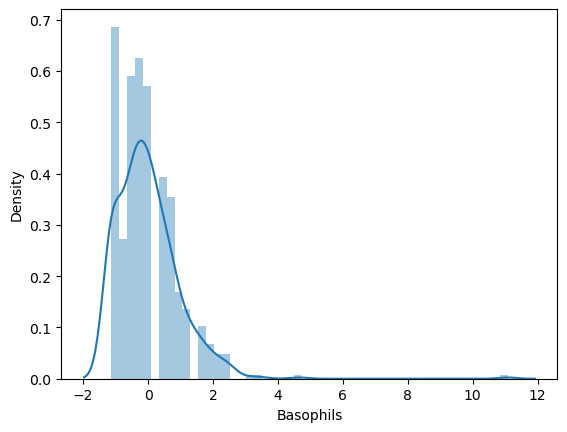

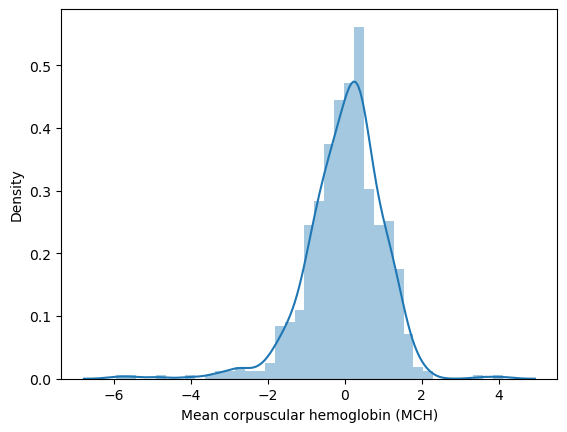

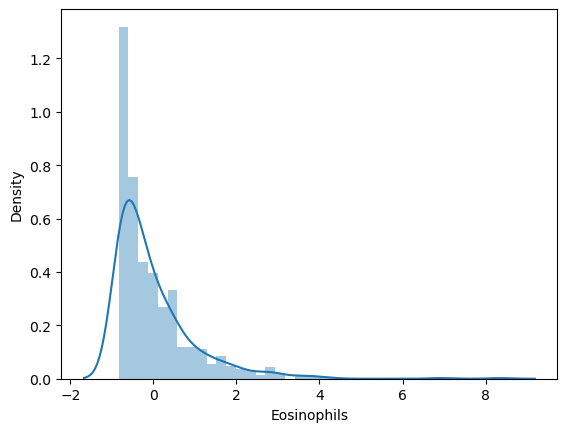

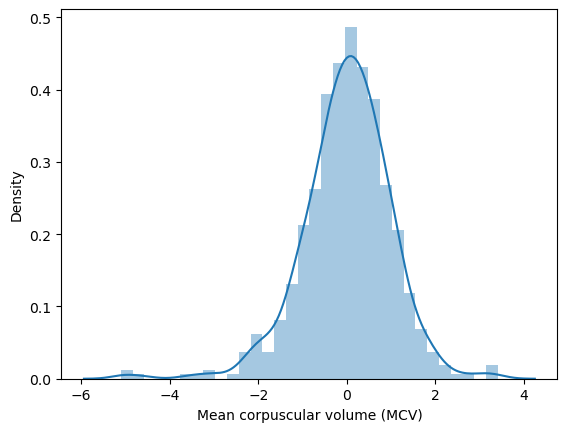

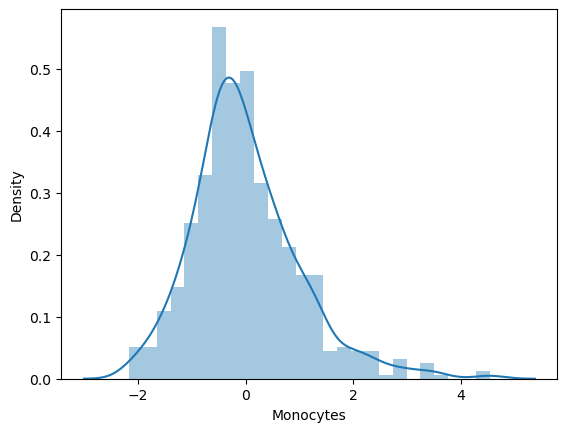

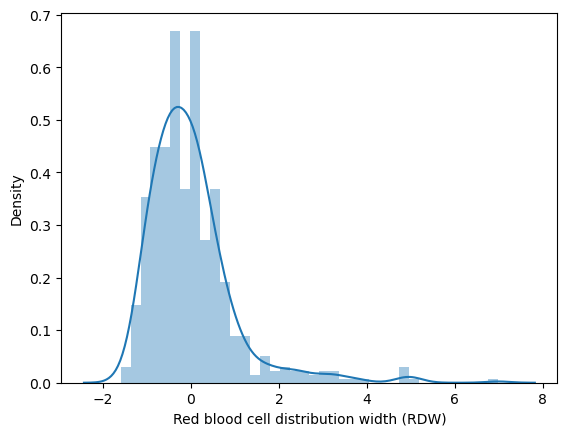

In [49]:
for col in df.select_dtypes('float'):
    #print(col)
    plt.figure()
    sns.distplot(df[col])

C:\Users\Fitiavana(GhosT)\AppData\Local\Temp\ipykernel_2400\3008645451.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["Patient age quantile"])


<Axes: xlabel='Patient age quantile', ylabel='Density'>

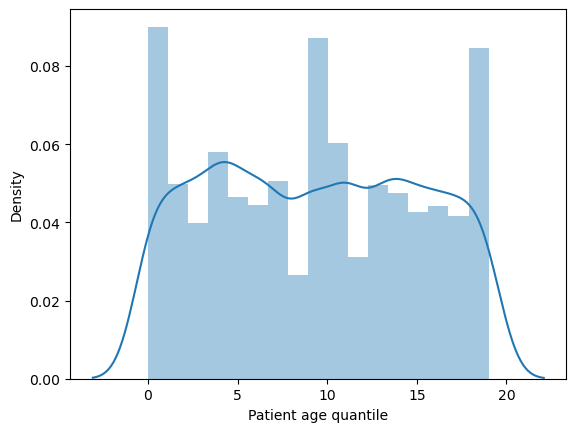

In [50]:
sns.distplot(df["Patient age quantile"])

In [51]:
df["Patient age quantile"].value_counts()

11    380
4     366
9     359
0     334
7     319
2     315
13    313
14    299
5     294
6     281
16    279
19    275
15    269
17    263
18    259
3     251
1     234
12    197
10    190
8     167
Name: Patient age quantile, dtype: int64

In [52]:
for col in df.select_dtypes('object'):
    print(f'{col :-<50} {df[col].unique()}')

SARS-Cov-2 exam result---------------------------- ['negative' 'positive']
Respiratory Syncytial Virus----------------------- [nan 'not_detected' 'detected']
Influenza A--------------------------------------- [nan 'not_detected' 'detected']
Influenza B--------------------------------------- [nan 'not_detected' 'detected']
Parainfluenza 1----------------------------------- [nan 'not_detected' 'detected']
CoronavirusNL63----------------------------------- [nan 'not_detected' 'detected']
Rhinovirus/Enterovirus---------------------------- [nan 'detected' 'not_detected']
Coronavirus HKU1---------------------------------- [nan 'not_detected' 'detected']
Parainfluenza 3----------------------------------- [nan 'not_detected' 'detected']
Chlamydophila pneumoniae-------------------------- [nan 'not_detected' 'detected']
Adenovirus---------------------------------------- [nan 'not_detected' 'detected']
Parainfluenza 4----------------------------------- [nan 'not_detected' 'detected']
Coronavirus2

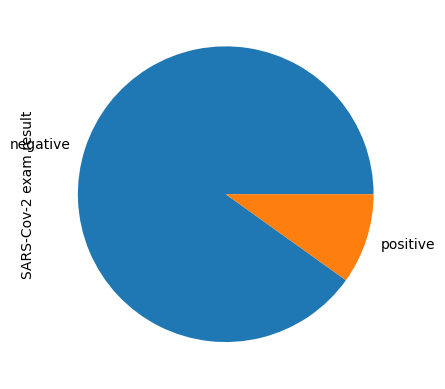

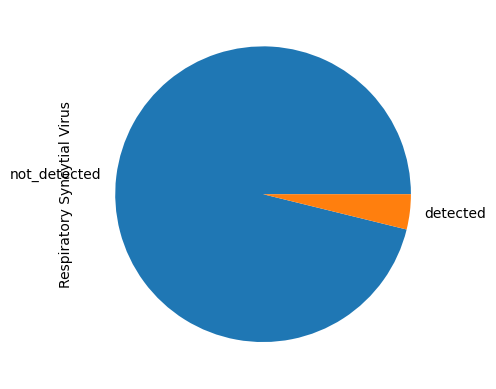

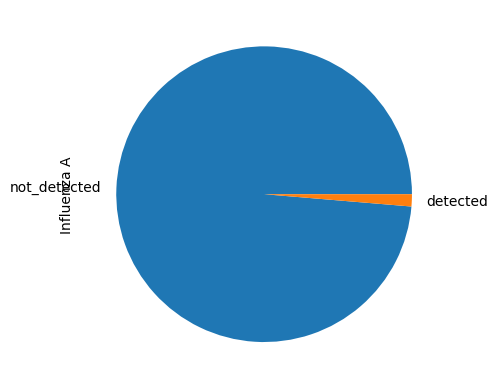

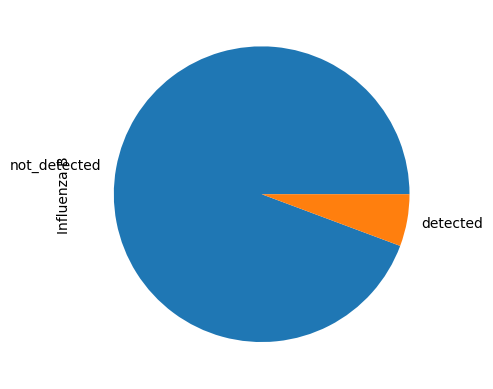

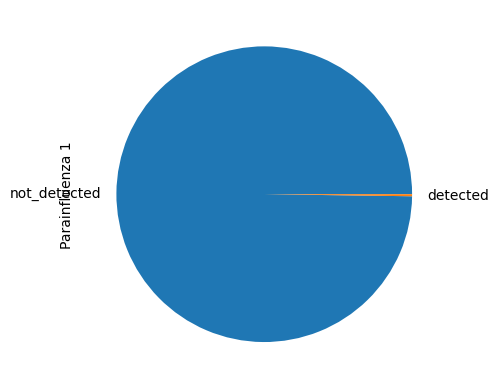

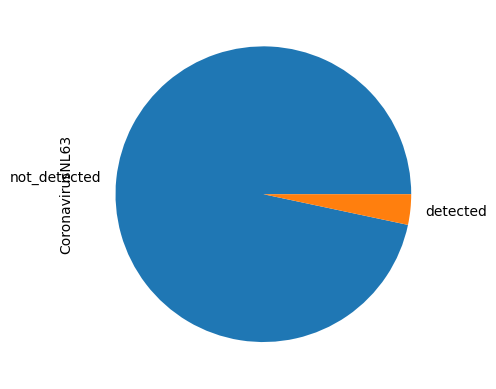

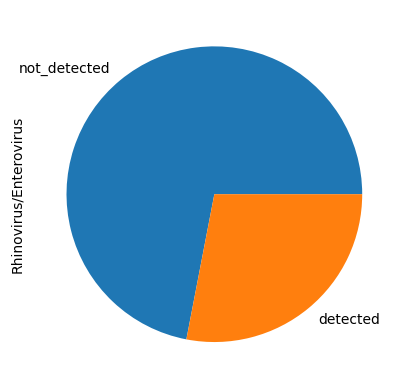

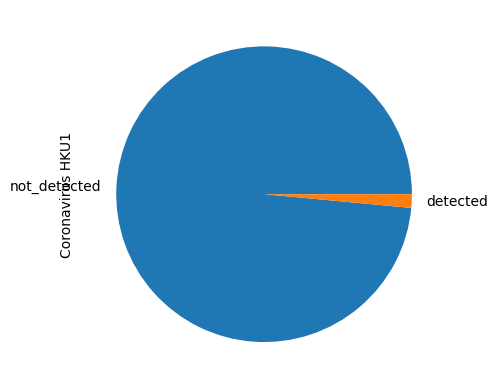

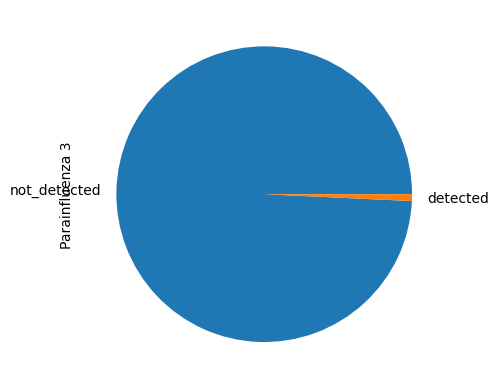

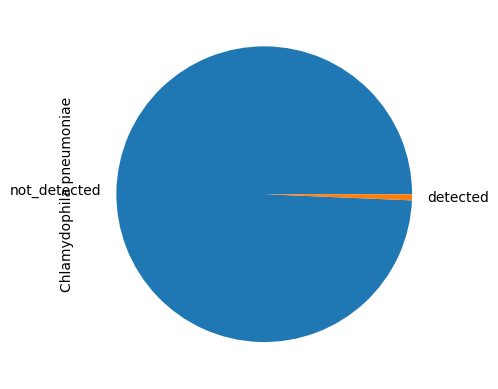

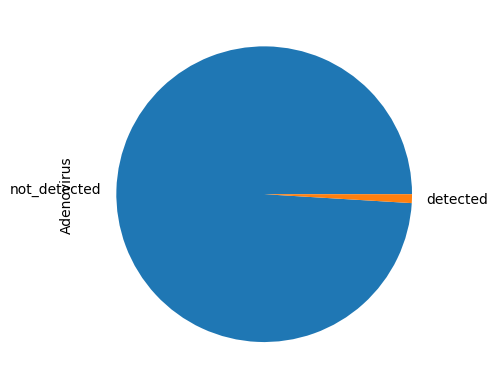

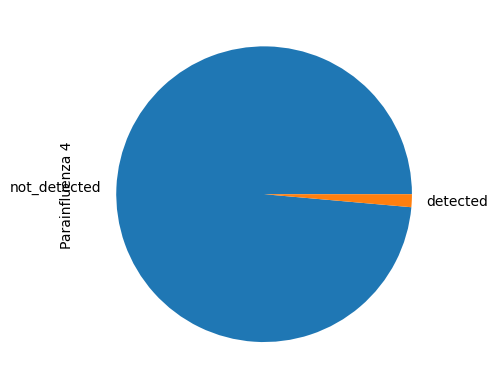

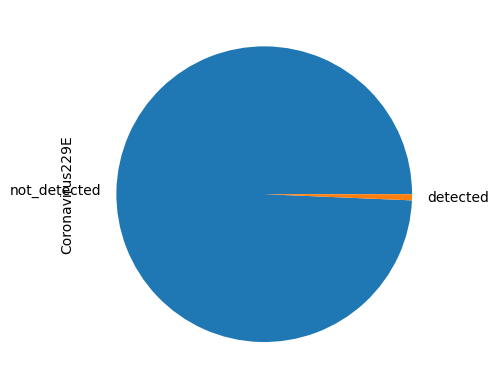

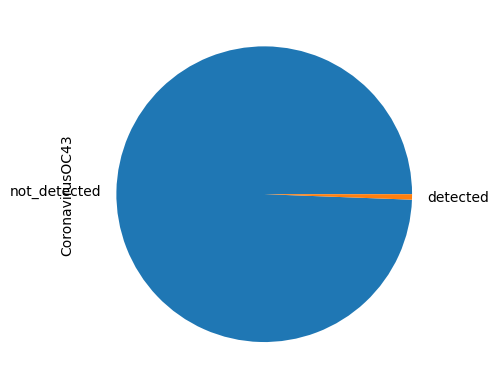

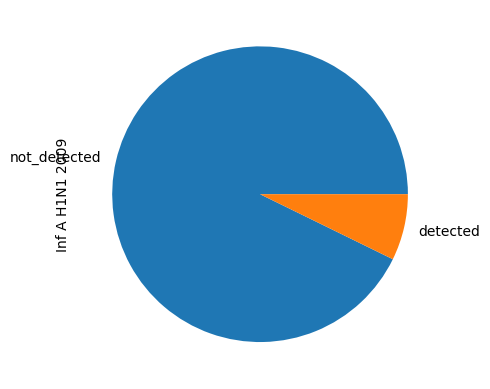

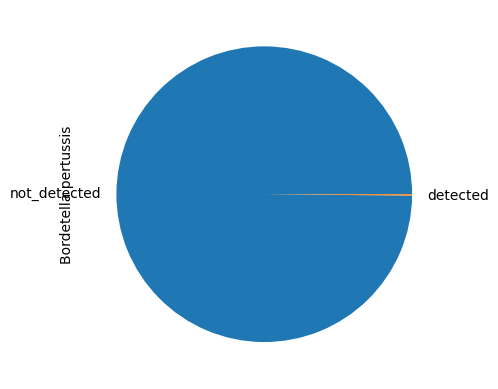

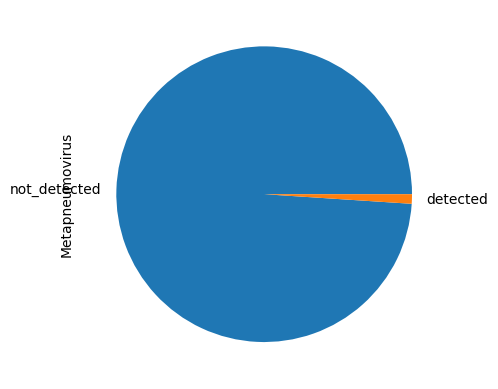

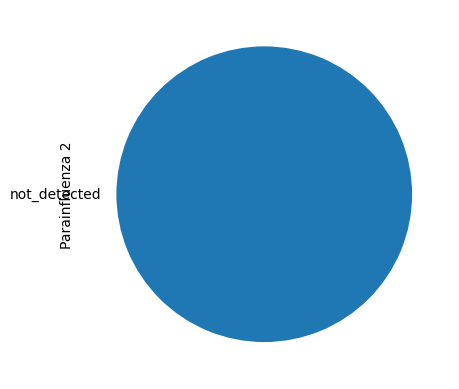

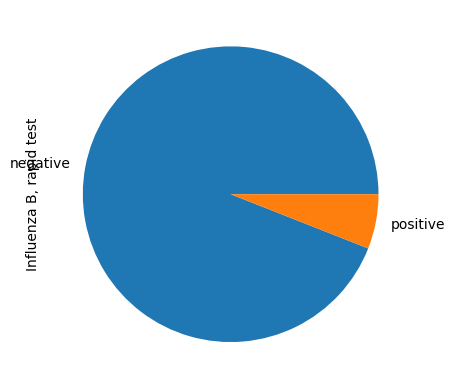

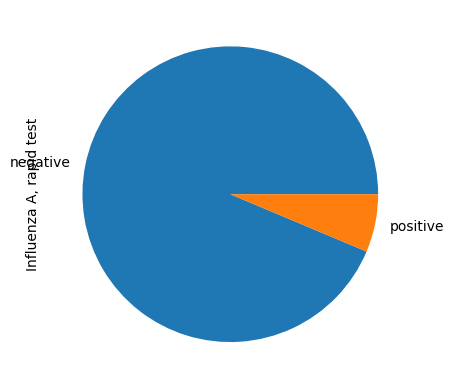

In [53]:
for col in df.select_dtypes('object'):
    plt.figure()
    df[col].value_counts().plot.pie()

### Relation Target / Variable

In [54]:
positive_df = df[df['SARS-Cov-2 exam result'] == 'positive']

In [55]:
negative_df = df[df['SARS-Cov-2 exam result'] == 'negative']

In [56]:
negative_df.shape

(5086, 38)

In [57]:
positive_df.shape

(558, 38)

#### Creattion Sous-Ensemble Blood & viral

In [58]:
missing_rate = df.isna().sum() / df.shape[0] 
df_blood_columns = df.columns[(missing_rate < 0.9) & (missing_rate > 0.88)]
df_viral_columns = df.columns[(missing_rate < 0.88) & (missing_rate > 0.75)]

In [59]:
df_viral_columns 

Index(['Respiratory Syncytial Virus', 'Influenza A', 'Influenza B',
       'Parainfluenza 1', 'CoronavirusNL63', 'Rhinovirus/Enterovirus',
       'Coronavirus HKU1', 'Parainfluenza 3', 'Chlamydophila pneumoniae',
       'Adenovirus', 'Parainfluenza 4', 'Coronavirus229E', 'CoronavirusOC43',
       'Inf A H1N1 2009', 'Bordetella pertussis', 'Metapneumovirus',
       'Parainfluenza 2', 'Influenza B, rapid test',
       'Influenza A, rapid test'],
      dtype='object')

C:\Users\Fitiavana(GhosT)\AppData\Local\Temp\ipykernel_2400\1468950737.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(positive_df[col],label="positive")
C:\Users\Fitiavana(GhosT)\AppData\Local\Temp\ipykernel_2400\1468950737.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(negative_df[col

C:\Users\Fitiavana(GhosT)\AppData\Local\Temp\ipykernel_2400\1468950737.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(negative_df[col],label="negative")
C:\Users\Fitiavana(GhosT)\AppData\Local\Temp\ipykernel_2400\1468950737.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(positive_df[col

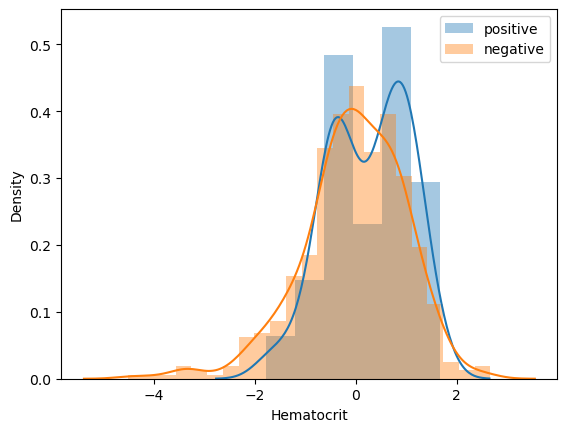

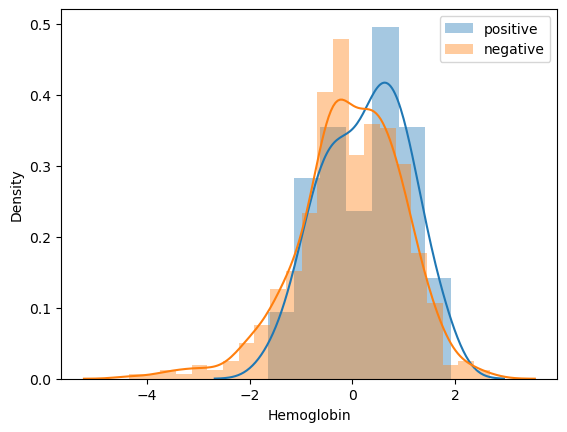

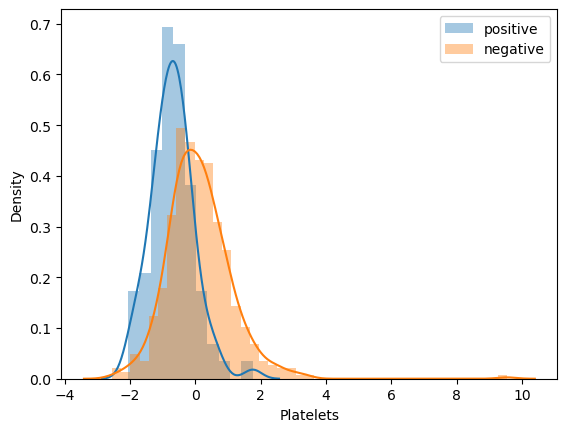

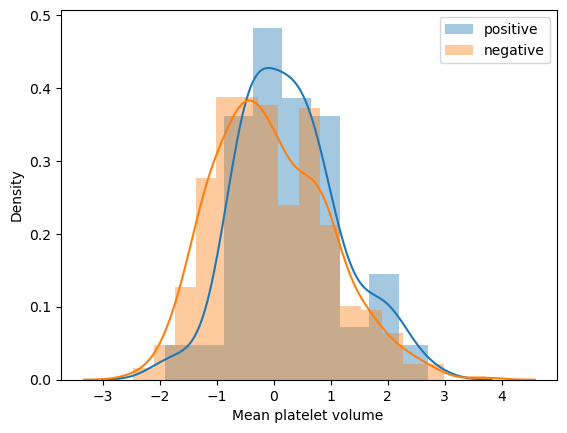

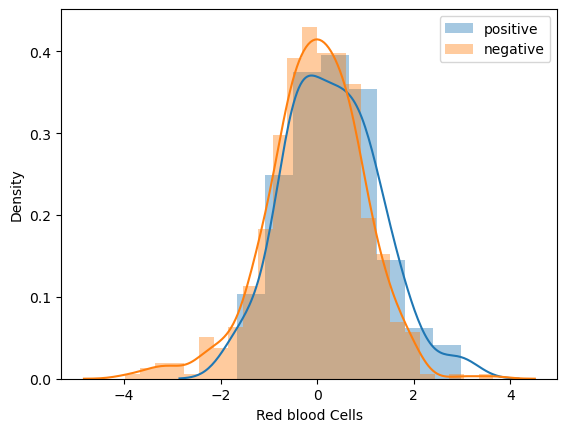

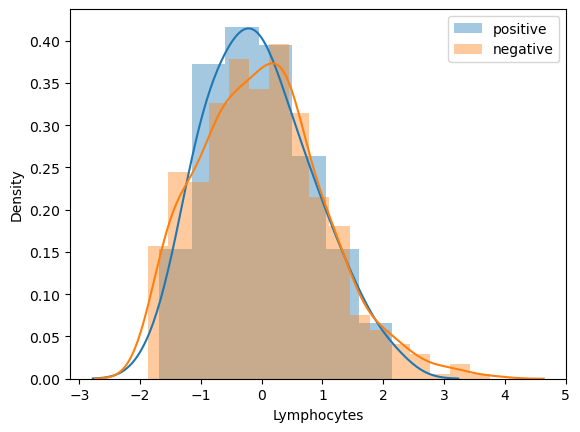

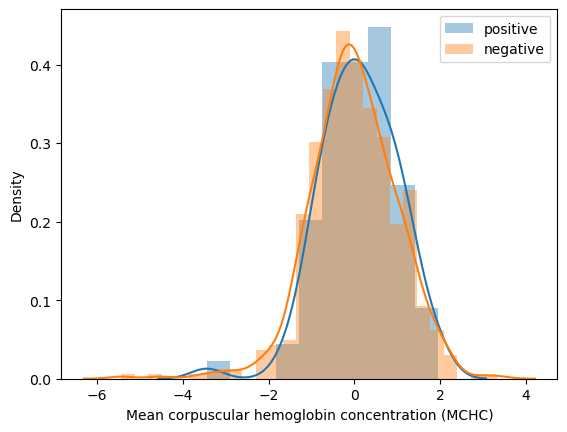

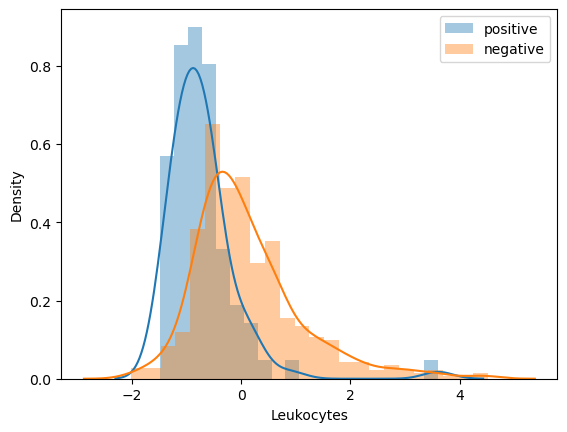

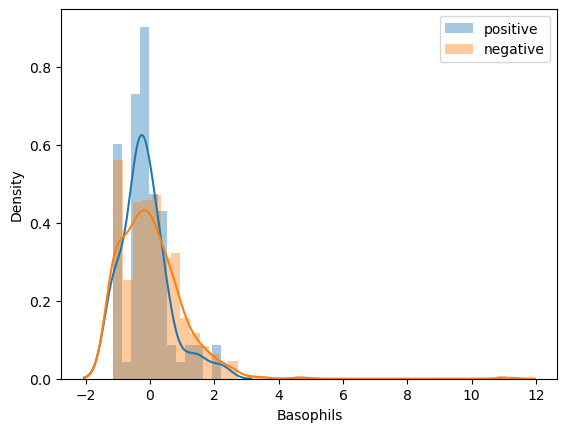

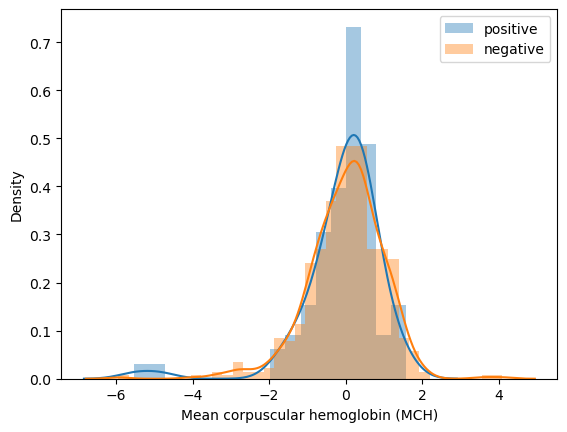

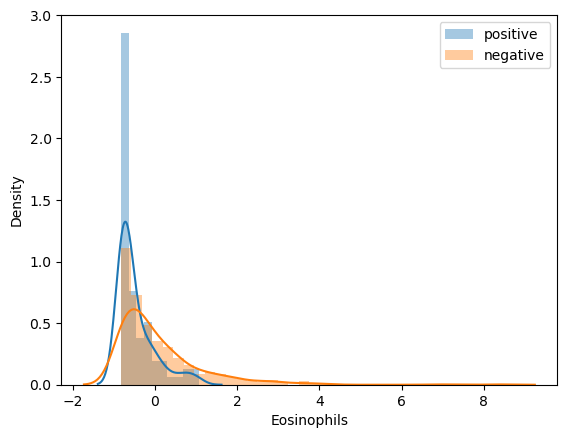

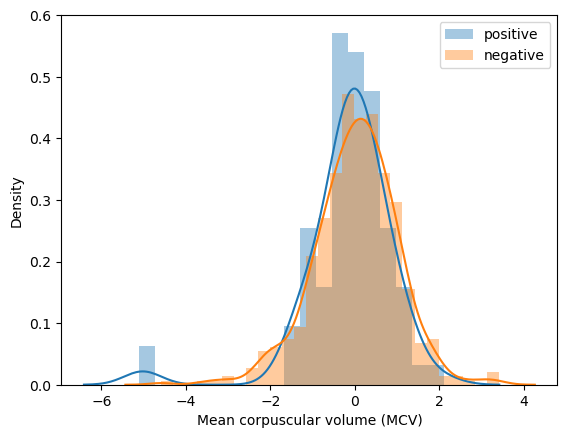

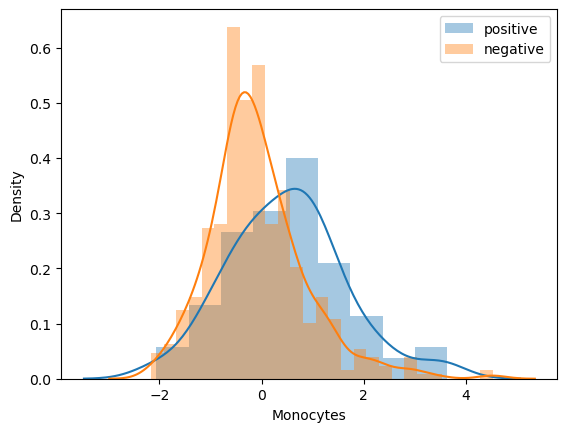

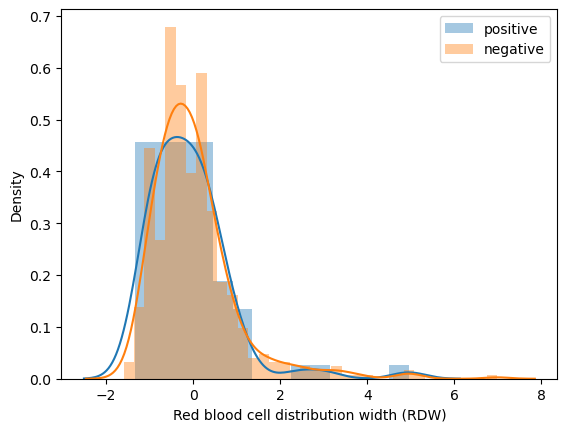

In [60]:
for col in df_blood_columns:
    plt.figure()
    sns.distplot(positive_df[col],label="positive")
    sns.distplot(negative_df[col],label="negative")
    plt.legend()

## Relation Target/age

<Axes: xlabel='Patient age quantile', ylabel='count'>

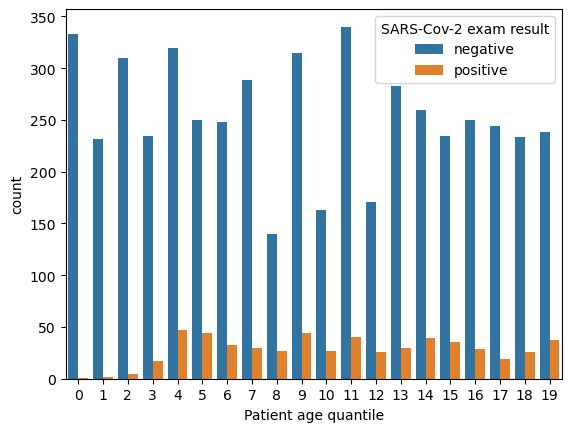

In [61]:
sns.countplot(x="Patient age quantile",hue="SARS-Cov-2 exam result",data=df)

## Relation Target/Viral

In [62]:
pd.crosstab(df['SARS-Cov-2 exam result'],df['Influenza A'])

Influenza A             detected  not_detected
SARS-Cov-2 exam result                        
negative                      18          1224
positive                       0           112

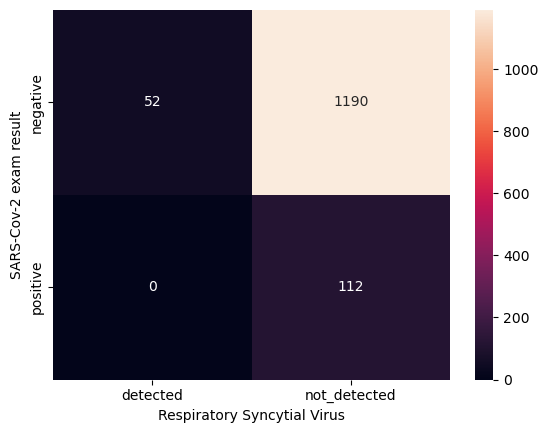

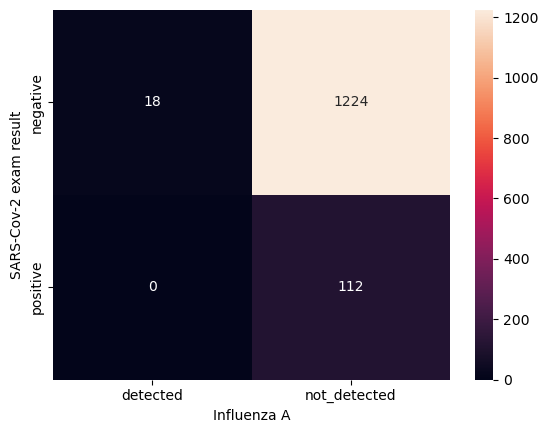

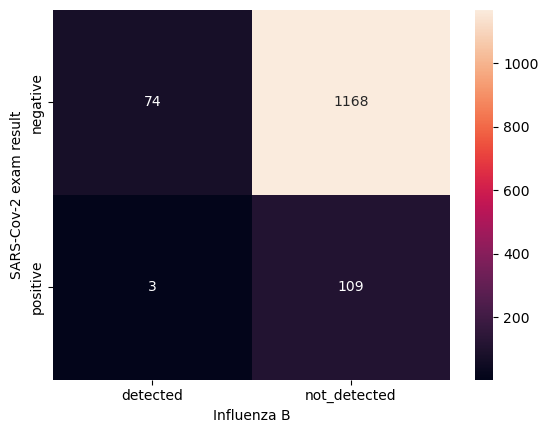

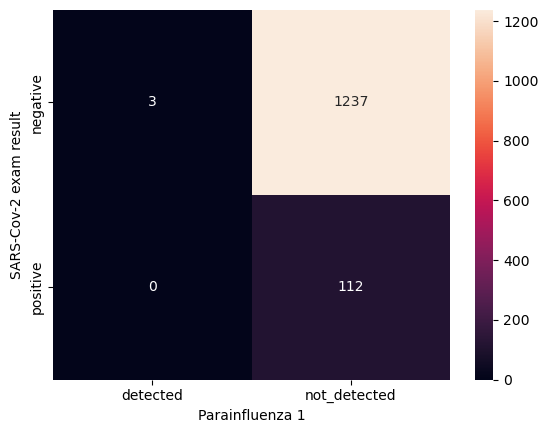

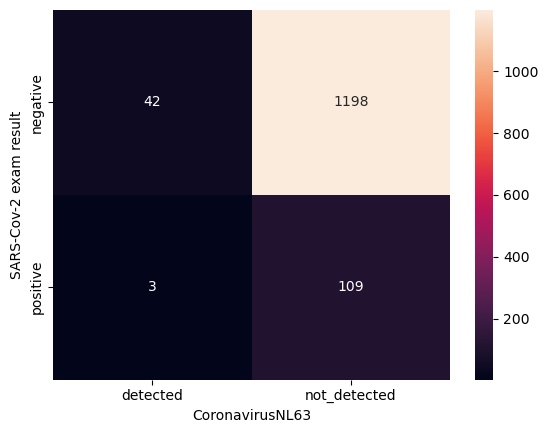

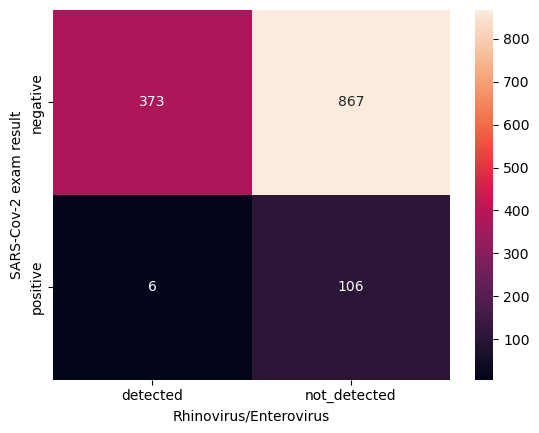

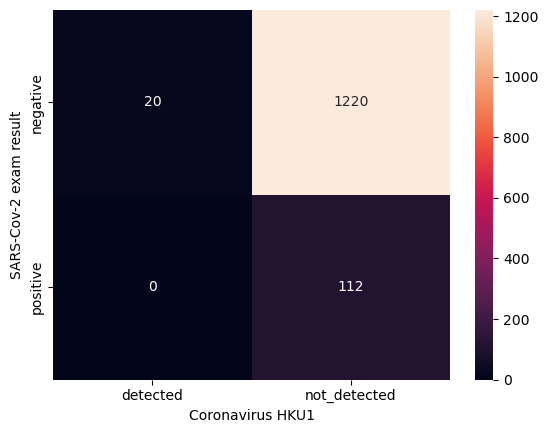

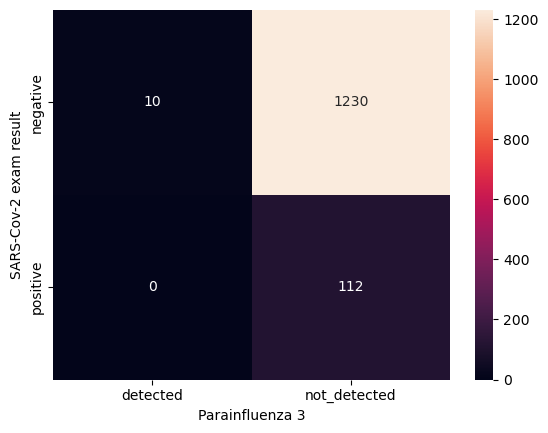

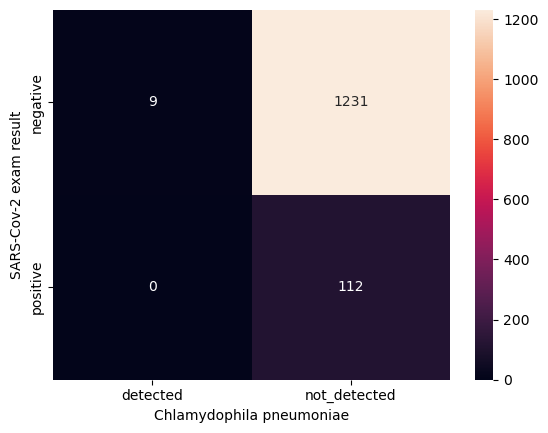

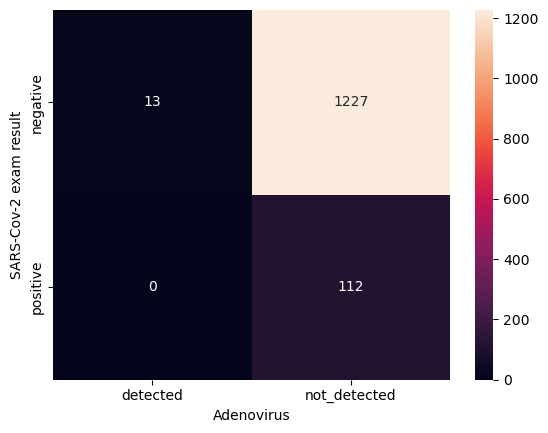

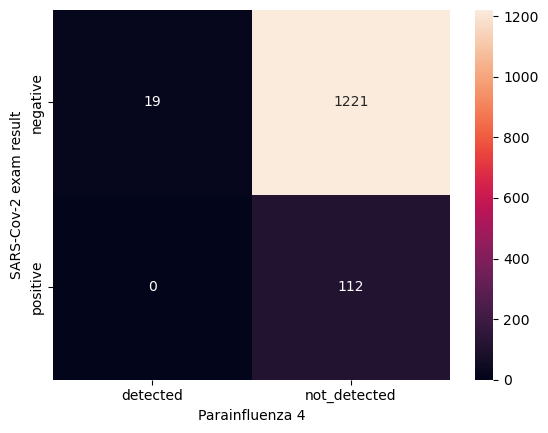

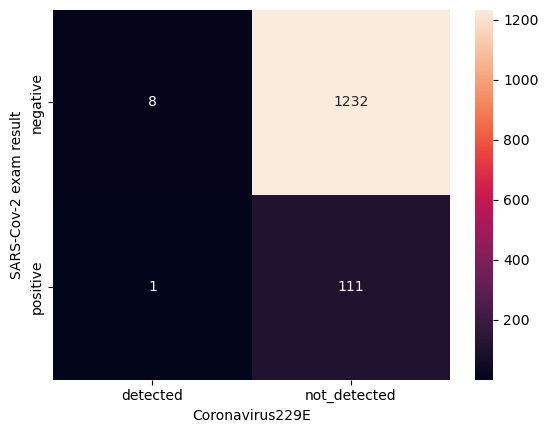

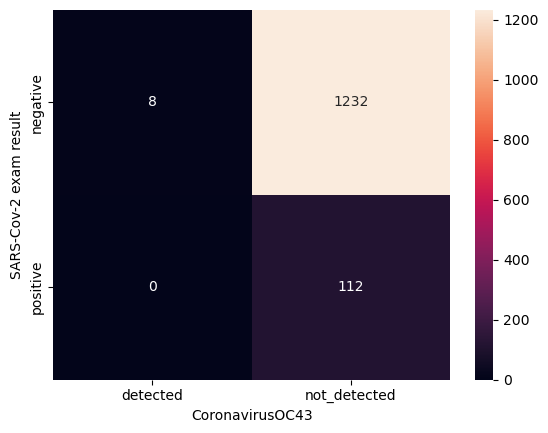

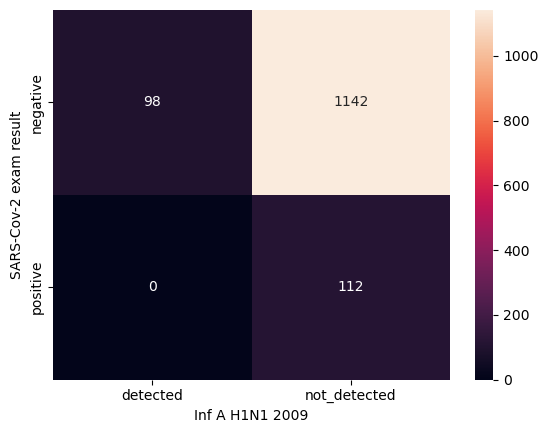

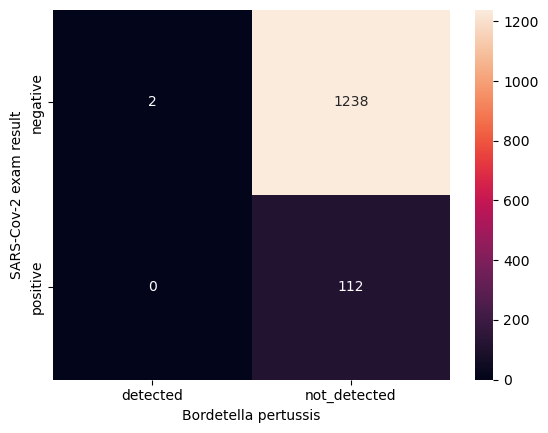

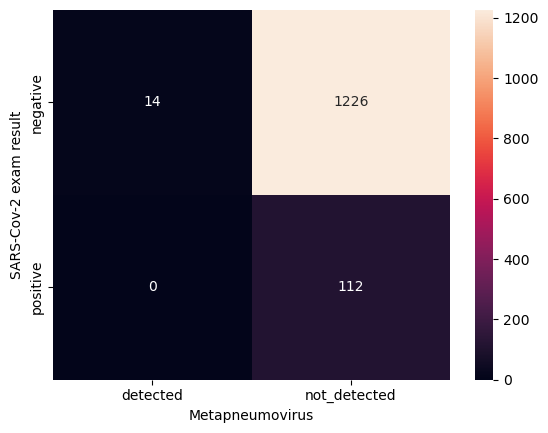

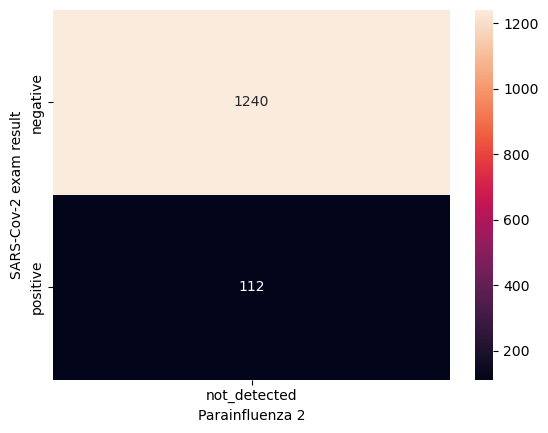

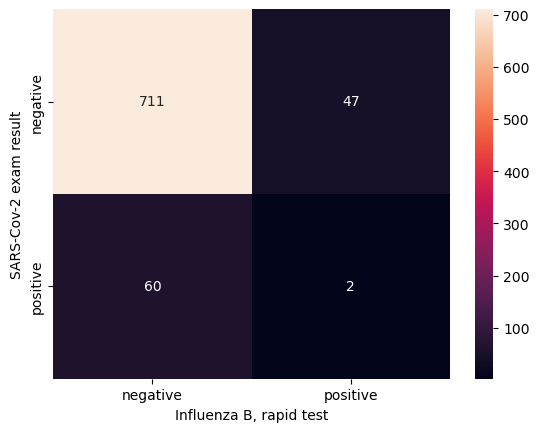

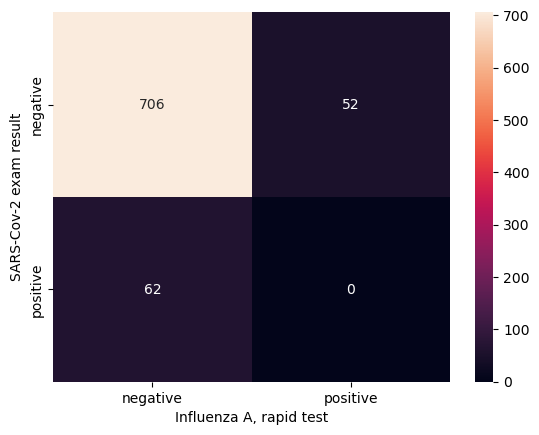

In [63]:
for col in  df_viral_columns:
    plt.figure()
    sns.heatmap(pd.crosstab(df['SARS-Cov-2 exam result'],df[col]),annot=True,fmt='d')

#### Analyse plus détaillée
- Relation Variables / Variables :
    - blood_data / blood_data : certaines variables sont tres corrélées : +0.9 (a suveiller plus tard)
    - blood_data / age : tres faible corrélation entre age et taux sanguins
    - viral / viral : influenza rapid test donne de mauvais résultats, il fauda peut-etre la laisser tomber
    - relation maladie / blood data : Les taux sanguins entre malades et covid-19 sont différents
    - relation hospitalisation / est malade :
    - relation hospitalisation / blood : intéressant dans le cas ou on voudrait prédire dans quelle service un patient devrait aller
- NaN analyse : viral : 1350(92/8), blood : 600(87/13), both : 90

#### hypotheses nulle (H0):
- Les individus atteints du covid-19 ont des taux de Leukocytes, Monocytes, Platelets significativement différents

H0 = Les taux moyens sont ÉGAUX chez les individus positifs et négatifs
- Les individus atteints d'une quelconque maladie ont des taux significativement différents

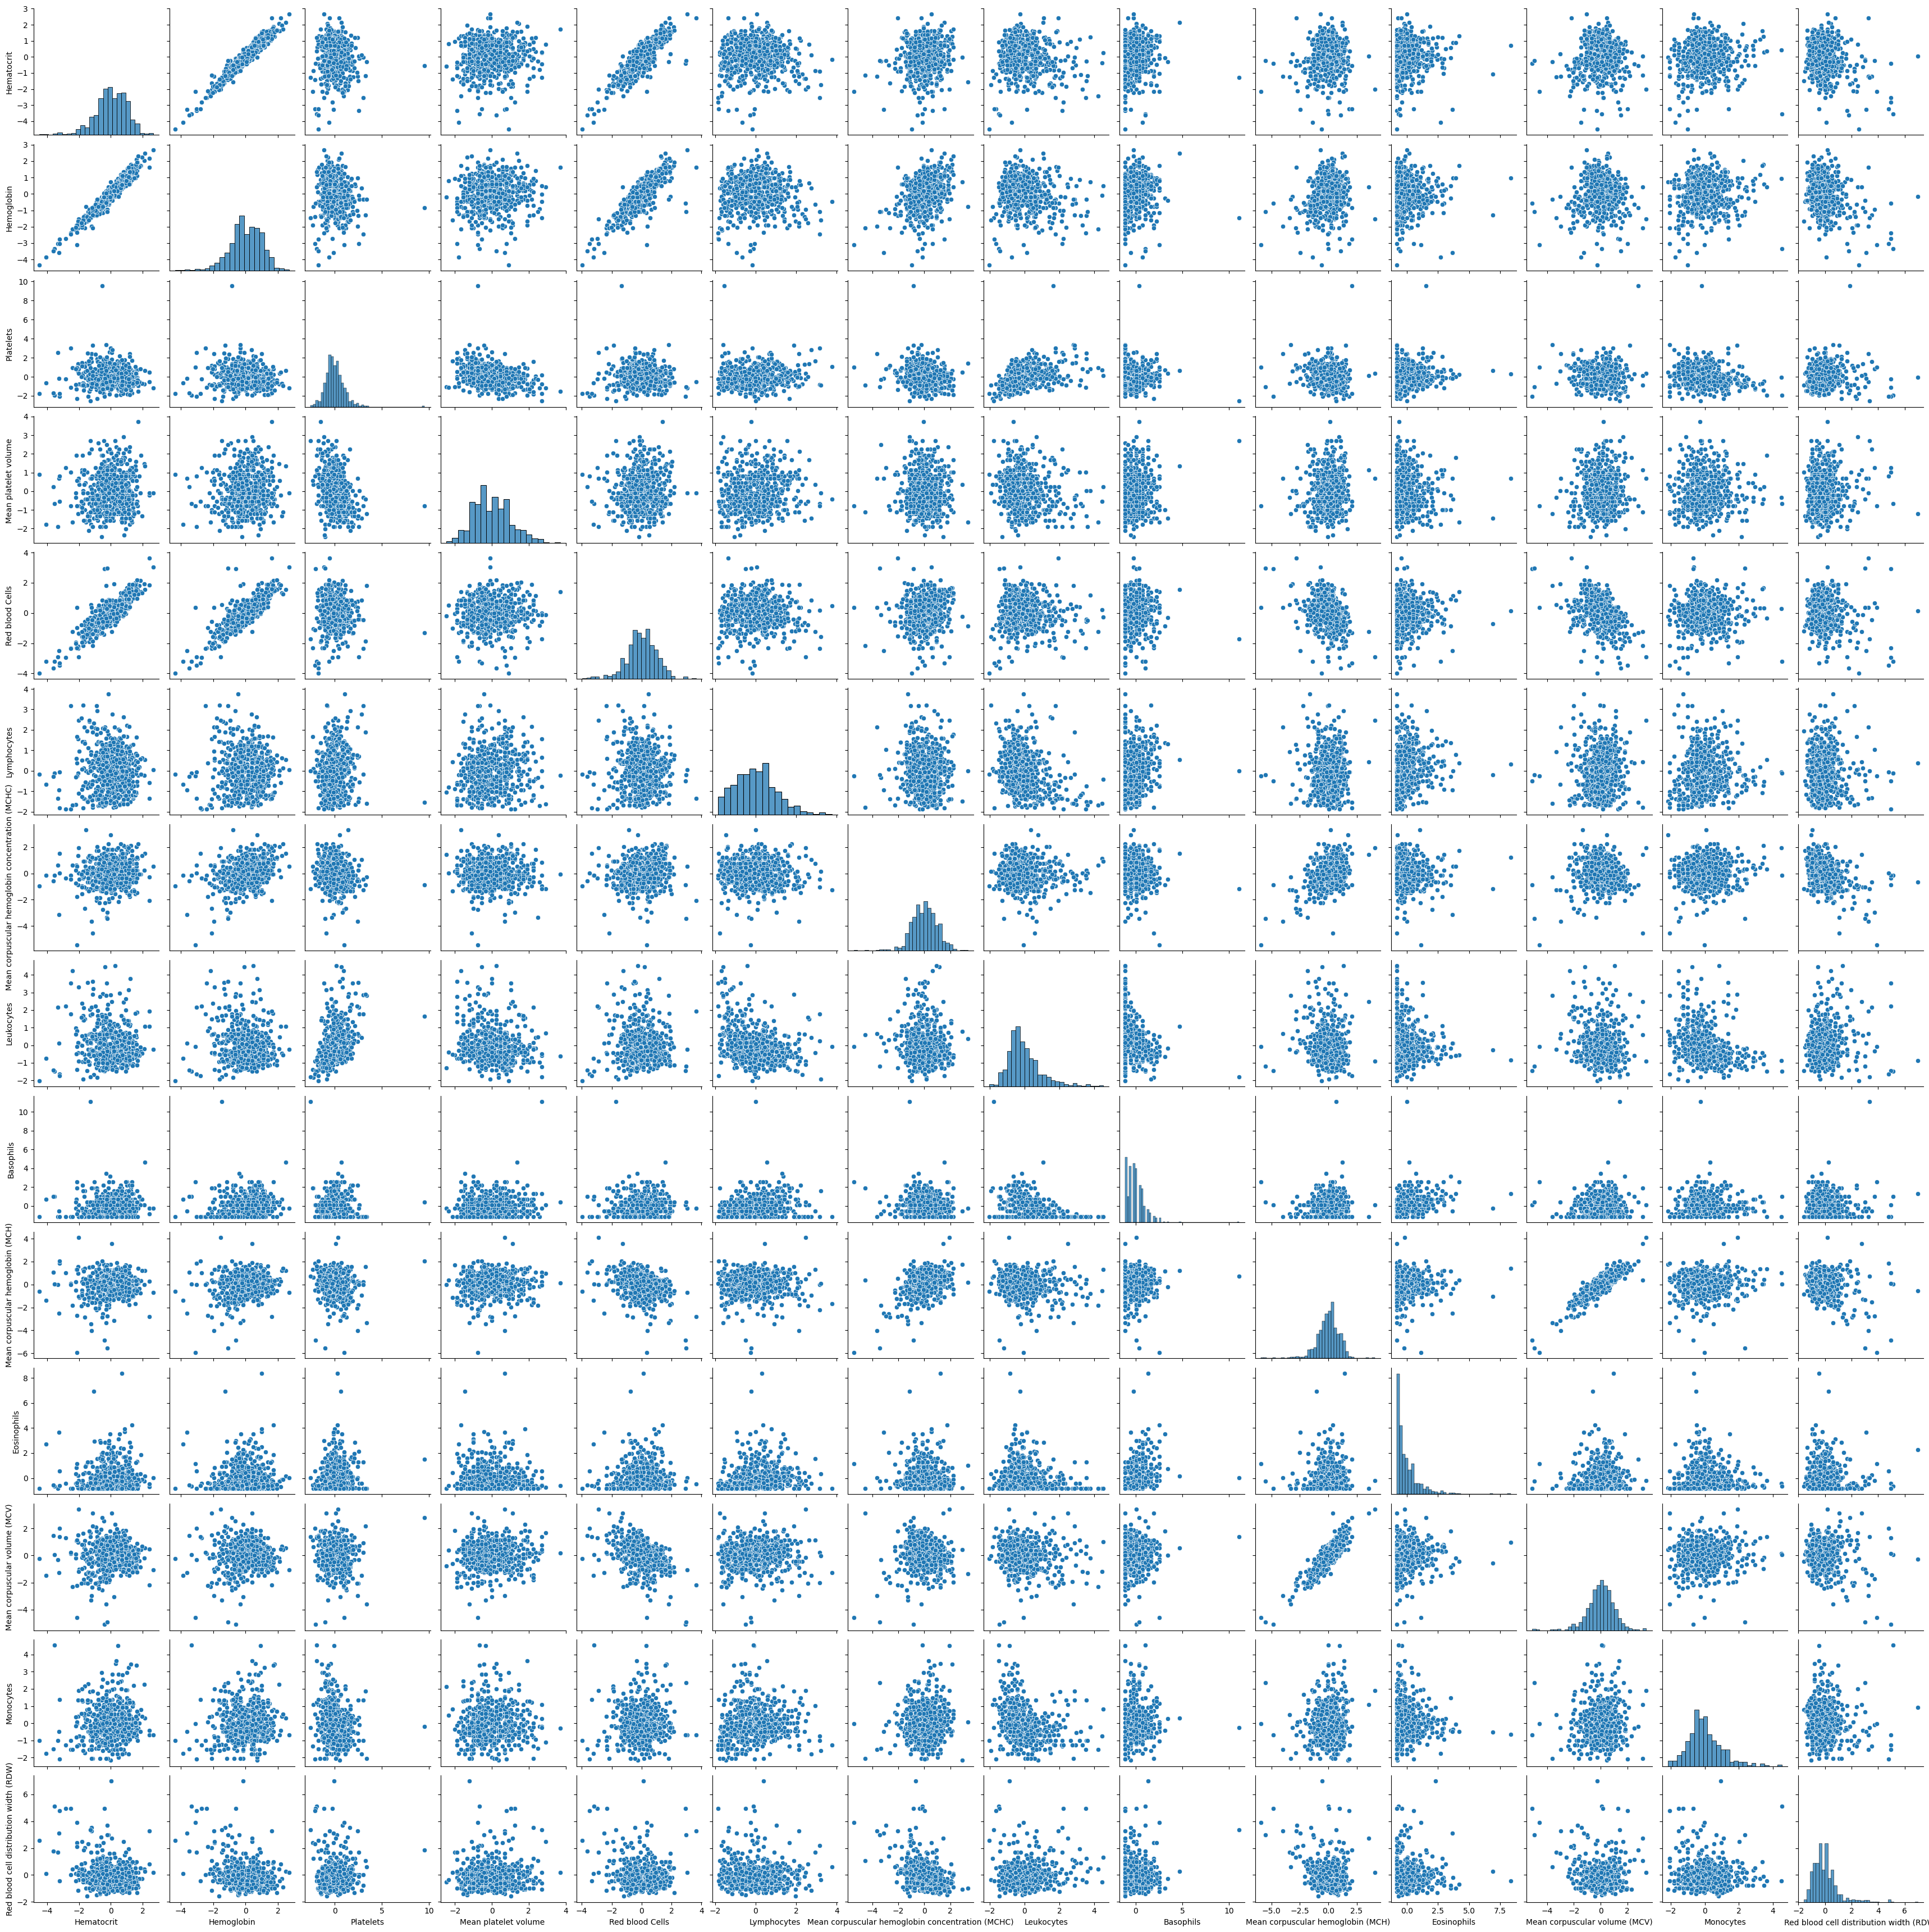

In [68]:
sns.pairplot(df[df_blood_columns])

<Axes: >

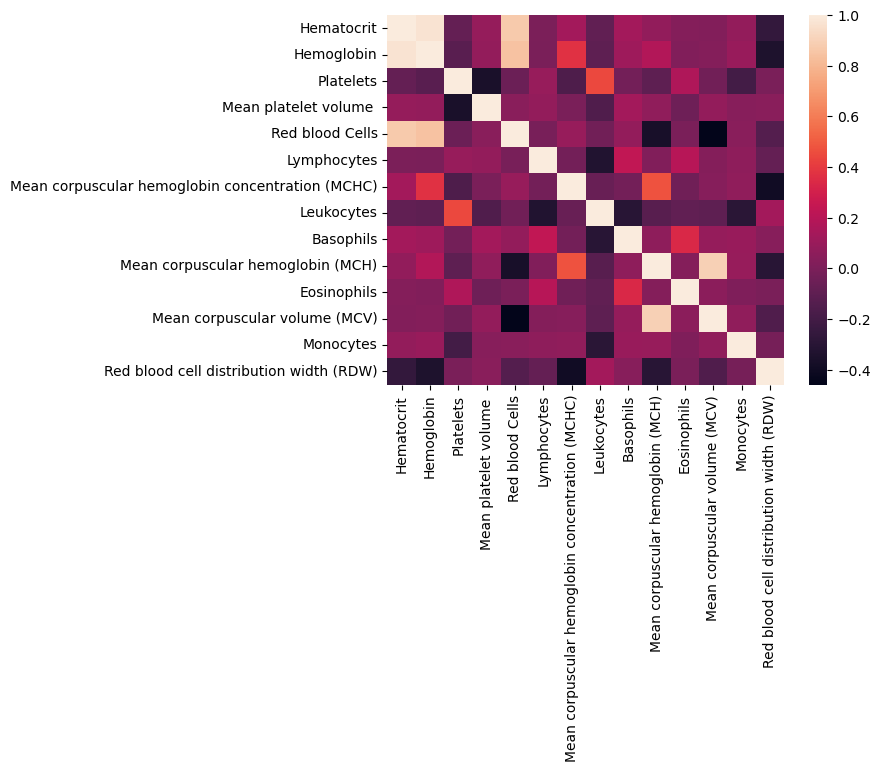

In [69]:
sns.heatmap(df[df_blood_columns].corr())

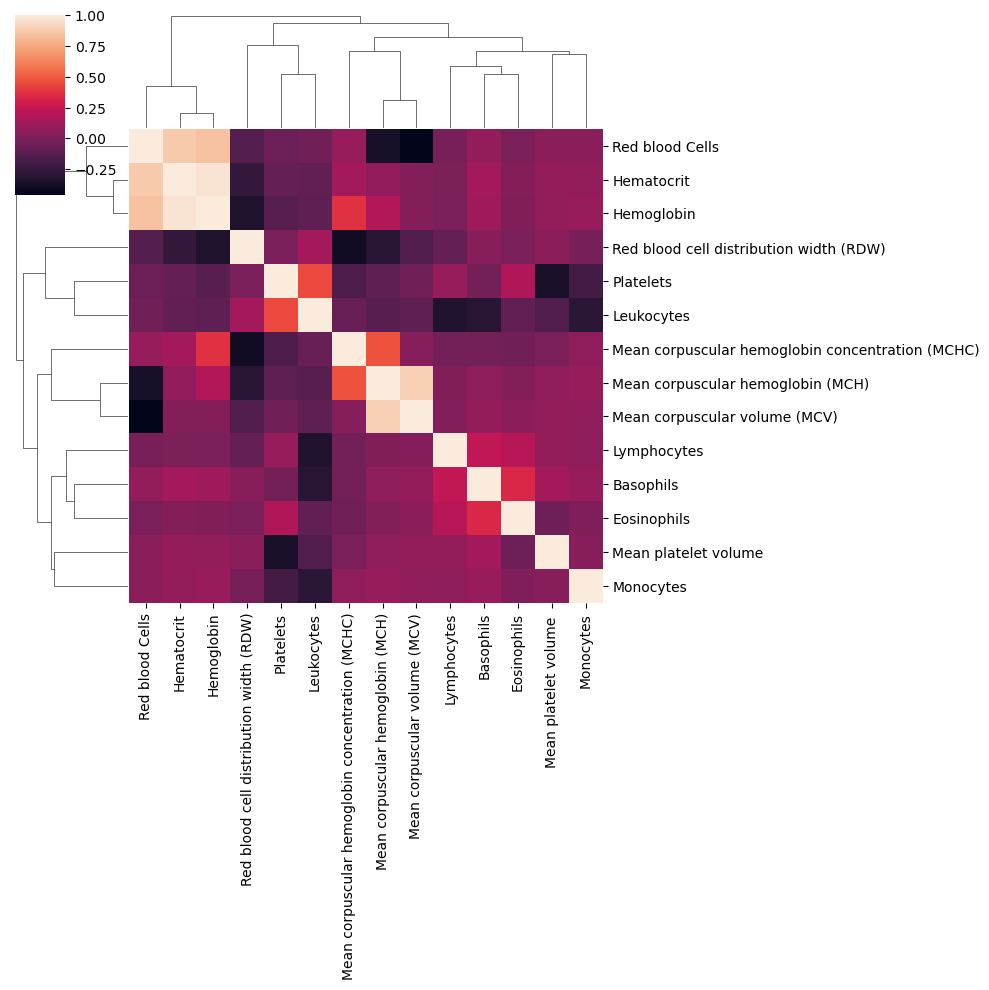

In [70]:
sns.clustermap(df[df_blood_columns].corr())

C:\Users\Fitiavana(GhosT)\AppData\Local\Temp\ipykernel_2400\2083957805.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

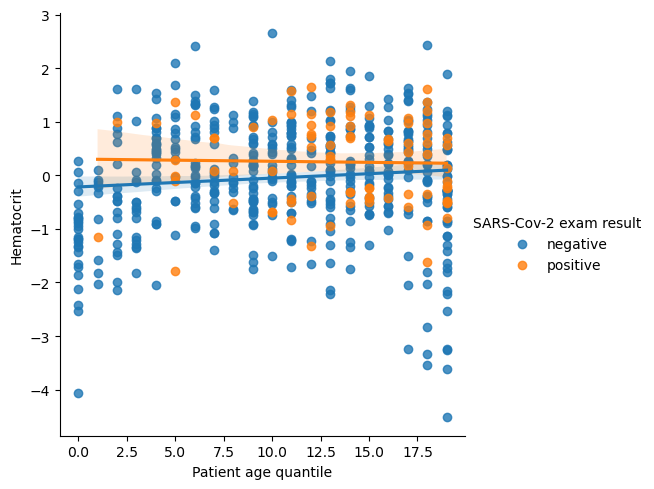

<Figure size 640x480 with 0 Axes>

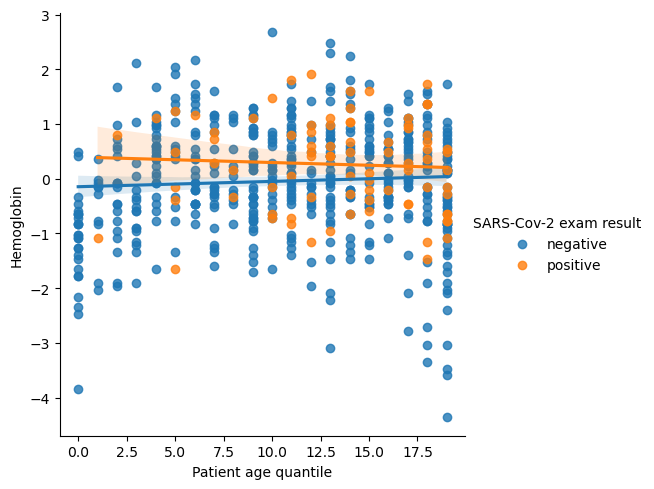

<Figure size 640x480 with 0 Axes>

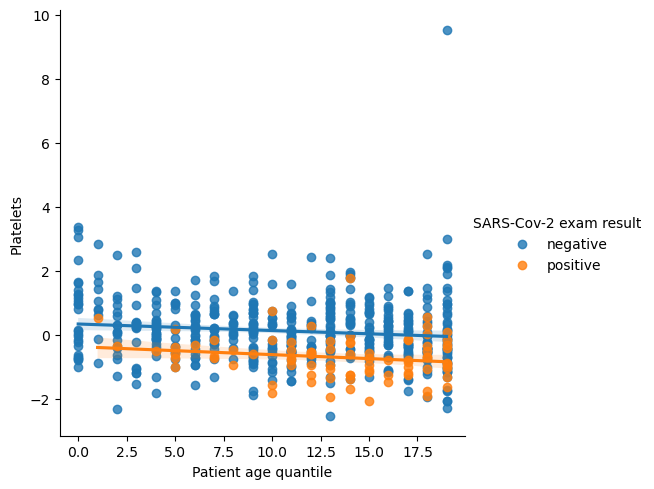

<Figure size 640x480 with 0 Axes>

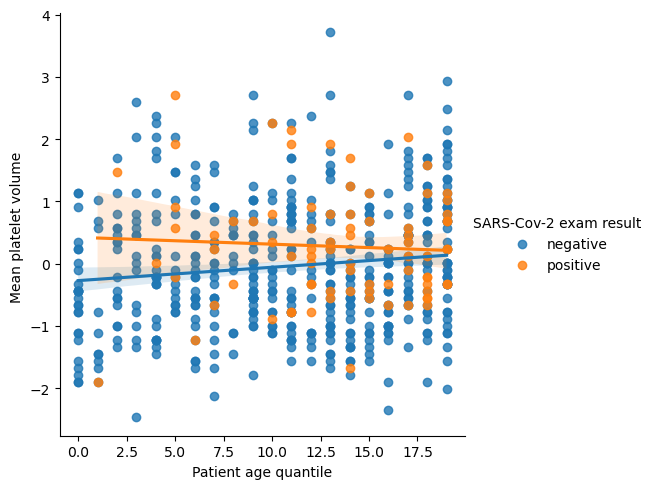

<Figure size 640x480 with 0 Axes>

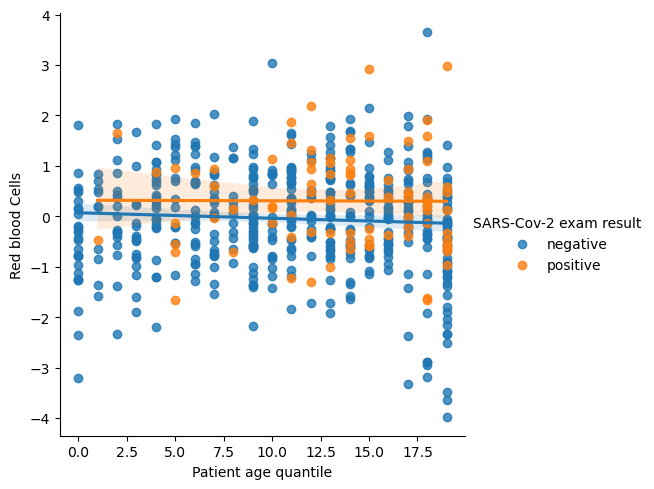

<Figure size 640x480 with 0 Axes>

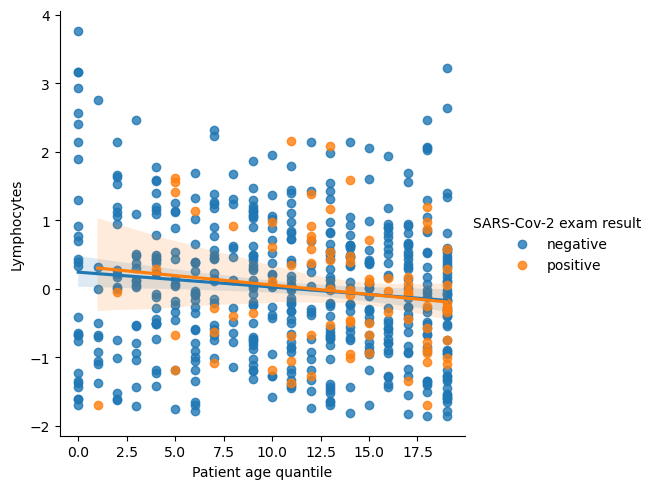

<Figure size 640x480 with 0 Axes>

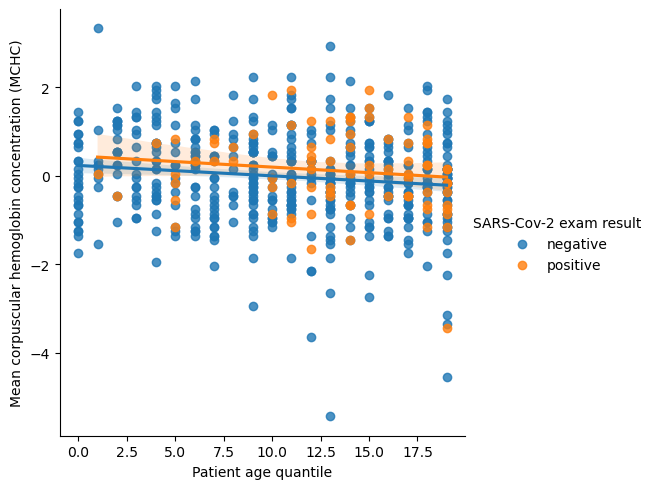

<Figure size 640x480 with 0 Axes>

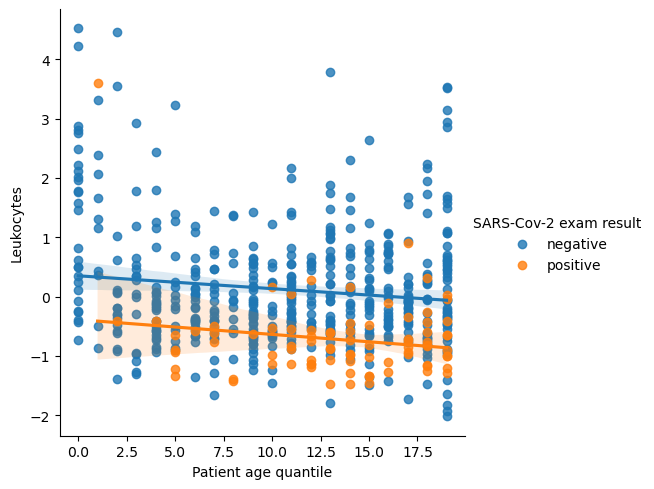

<Figure size 640x480 with 0 Axes>

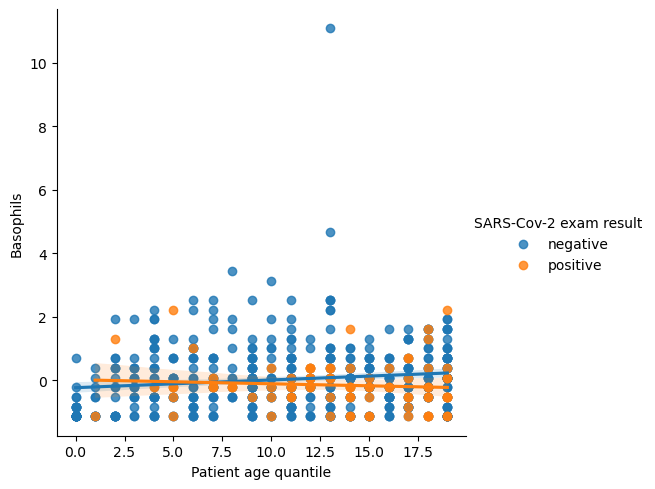

<Figure size 640x480 with 0 Axes>

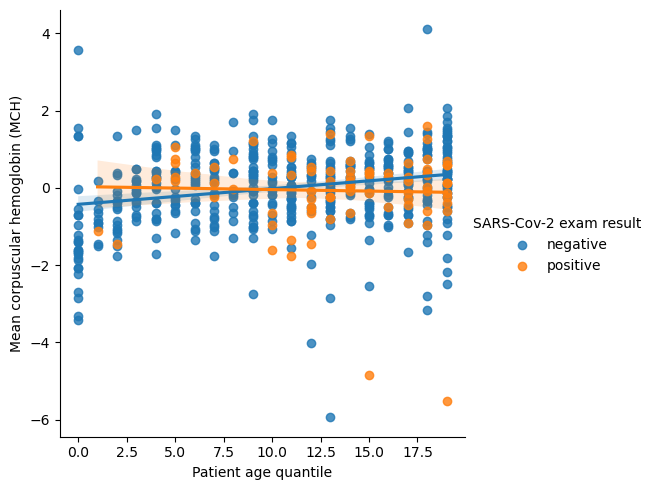

<Figure size 640x480 with 0 Axes>

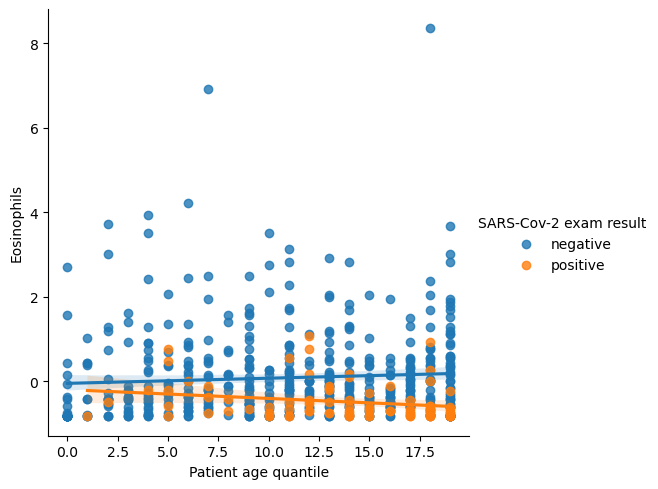

<Figure size 640x480 with 0 Axes>

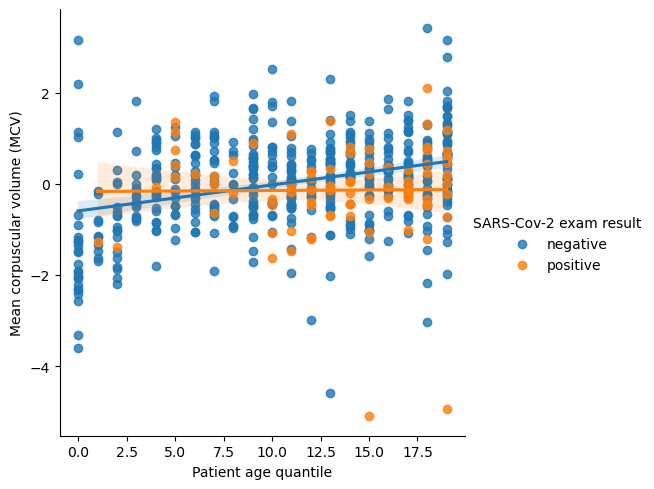

<Figure size 640x480 with 0 Axes>

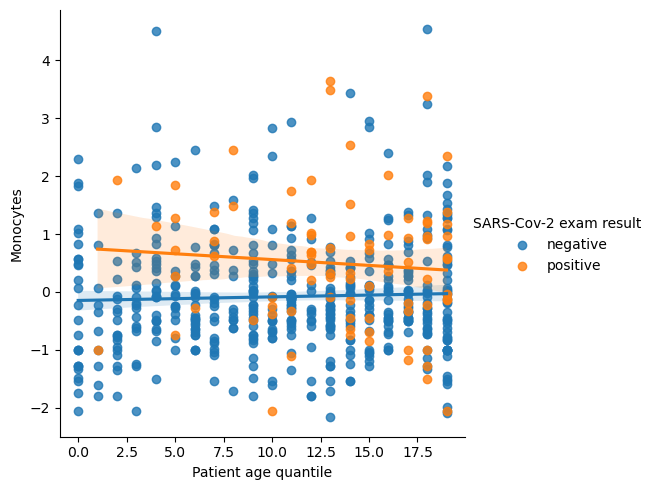

<Figure size 640x480 with 0 Axes>

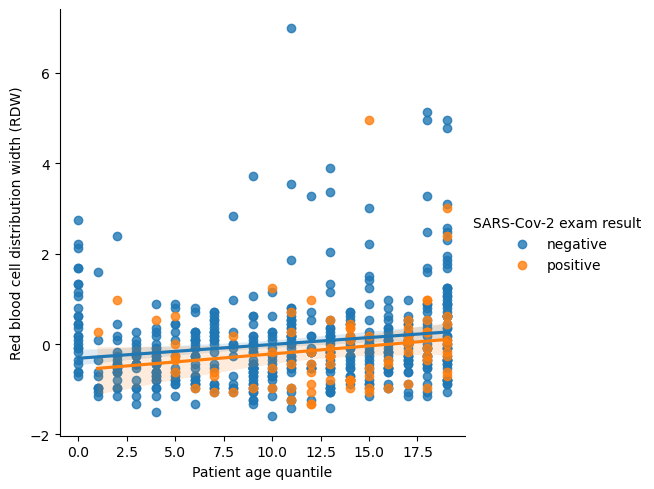

In [75]:
for col in df_blood_columns:
    plt.figure()
    sns.lmplot(x="Patient age quantile",y=col,hue="SARS-Cov-2 exam result",data=df)

In [71]:
df.head()

Patient age quantile SARS-Cov-2 exam result  \
0                    13               negative   
1                    17               negative   
2                     8               negative   
3                     5               negative   
4                    15               negative   

   Patient addmited to regular ward (1=yes, 0=no)  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   Patient addmited to semi-intensive unit (1=yes, 0=no)  \
0                                                  0       
1                                                  0       
2                                                  0       
3                                                  0       
4                                                  0       

   Patient addmited to intensive care unit (1=yes, 0=no)  Hematocrit  \
0                                                  0             NaN   
1                                                  0        0.236515   
2                                                  0             NaN   
3                                                  0             NaN   
4                                                  0             NaN   

   Hemoglobin  Platelets  Mean platelet volume   Red blood Cells  Lymphocytes  \
0         NaN        NaN                    NaN              NaN          NaN   
1    -0.02234  -0.517413               0.010677         0.102004     0.318366   
2         NaN        NaN                    NaN              NaN          NaN   
3         NaN        NaN                    NaN              NaN          NaN   
4         NaN        NaN                    NaN              NaN          NaN   

   Mean corpuscular hemoglobin concentration (MCHC)  Leukocytes  Basophils  \
0                                               NaN         NaN        NaN   
1                                          -0.95079    -0.09461  -0.223767   
2                                               NaN         NaN        NaN   
3                                               NaN         NaN        NaN   
4                                               NaN         NaN        NaN   

   Mean corpuscular hemoglobin (MCH)  Eosinophils  \
0                                NaN          NaN   
1                          -0.292269     1.482158   
2                                NaN          NaN   
3                                NaN          NaN   
4                                NaN          NaN   

   Mean corpuscular volume (MCV)  Monocytes  \
0                            NaN        NaN   
1                       0.166192   0.357547   
2                            NaN        NaN   
3                            NaN        NaN   
4                            NaN        NaN   

   Red blood cell distribution width (RDW) Respiratory Syncytial Virus  \
0                                      NaN                         NaN   
1                                -0.625073                not_detected   
2                                      NaN                         NaN   
3                                      NaN                         NaN   
4                                      NaN                not_detected   

    Influenza A   Influenza B Parainfluenza 1 CoronavirusNL63  \
0           NaN           NaN             NaN             NaN   
1  not_detected  not_detected    not_detected    not_detected   
2           NaN           NaN             NaN             NaN   
3           NaN           NaN             NaN             NaN   
4  not_detected  not_detected    not_detected    not_detected   

  Rhinovirus/Enterovirus Coronavirus HKU1 Parainfluenza 3  \
0                    NaN              NaN             NaN   
1               detected     not_detected    not_detected   
2           